In [ ]:
'''
Before astrometry, we need the integrate intensity map of each cube data (e.g., MIRI - CH1, CH2. CH3, CH4, NIRspec - G235H/F170LP, G395H/F290LP).
After astrometry, an integrated intensity map of each cube's data is required to verify that the astrometry method is functioning correctly.
'''

# Import

In [ ]:
import numpy as np
from glob import glob
from copy import deepcopy
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
from matplotlib.gridspec import GridSpec
from matplotlib.patches import Rectangle, Ellipse
import matplotlib.patches as patches
import matplotlib.transforms as transforms
from astropy.io import fits
from astropy.wcs import WCS
import astropy.wcs as wcs
from astropy.coordinates import SkyCoord  # High-level coordinates
from astropy.coordinates import ICRS, Galactic, FK4, FK5  # Low-level frames
from astropy.coordinates import Angle, Latitude, Longitude  # Angles
from photutils.aperture import SkyCircularAperture, ApertureStats
from astropy import units as u
from uncertainties import ufloat
from uncertainties.umath import *
from scipy.ndimage import shift
import os
import sys
from scipy.optimize import curve_fit
sys.path.append('/home/chkim/work/code/python/Module/')
from readfits import readfits_cont
from readfits import readfits_line
from readfits import readfits_mom
readfits_line = readfits_line()
readfits_cont = readfits_cont()
readfits_mom = readfits_mom()

from reproject import reproject_interp
def MatchingCoor(app_data, app_wcs, ref_data, ref_wcs):
    rep_data, footprint = reproject_interp((app_data, app_wcs), ref_wcs, shape_out=ref_data.shape)
    return rep_data

def hms2deg(RA, uncer):
    RA_h = float(RA.split(':')[0])
    RA_m = float(RA.split(':')[1])
    RA_s = float(RA.split(':')[2])
    RA_deg = 15*RA_h + 15*RA_m/60 + 15*RA_s/3600
    RA_uncer = 15*float(uncer)
    return RA_deg, RA_uncer
def dms2deg(Dec, Uncer):
    Dec_d = float(Dec.split(':')[0])
    Dec_m = float(Dec.split(':')[1])
    Dec_s = float(Dec.split(':')[2])
    Dec_deg = Dec_d + Dec_m/60 + Dec_s/3600
    return Dec_deg, float(Uncer)
from mpdaf.obj import deg2hms, deg2dms, dms2deg, hms2deg

def Cent_ApStats(w, data, r):
    Peak_data = np.where(data == np.nanmax(data))
    Peak_pix_ra = Peak_data[1][0] ; Peak_pix_dec = Peak_data[0][0]
    Peak_coords = w.pixel_to_world(Peak_pix_ra, Peak_pix_dec)

    ap = SkyCircularAperture(Peak_coords, r=r*u.arcsec)
    ap_stats = ApertureStats(data, ap, wcs=w)
    return ap, ap_stats

def Cent_ApStats_NS(w, data, Peak_pix_ra, Peak_pix_dec, r):
    Peak_coords = w.pixel_to_world(Peak_pix_ra, Peak_pix_dec)

    ap = SkyCircularAperture(Peak_coords, r=r*u.arcsec)
    ap_stats = ApertureStats(data, ap, wcs=w)
    return ap, ap_stats

dfig = '/saveFigurePath/'

# ALMA Continuum

In [ ]:
dALMA = 'dataPath/member.uid___A001_X2d20_X20a0.EC_53_sci.spw17_19_21_23.cont.selfcal.I.pbcor.fits'
header_alma, data_alma = readfits_cont.readcont(dALMA) ; data_alma = data_alma[0]
ContPeak = np.where(data_alma == np.nanmax(data_alma))
ContPeak_ra = ContPeak[1] ; ContPeak_dec = ContPeak[0]
w_alma = WCS(header_alma).celestial
ContPeak_coords = w_alma.pixel_to_world(ContPeak_ra, ContPeak_dec)
alma_contpeak_deg = ContPeak_coords

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [ ]:
alma_ap, alma_ap_stats = Cent_ApStats(WCS(header_alma).celestial, data_alma, 0.2)
alma_ap_cent_deg = alma_ap_stats.sky_centroid
alma_ap_centroid_ra = alma_ap_stats.centroid[0] ; alma_ap_centroid_dec = alma_ap_stats.centroid[1]

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


In [ ]:
del_ra_alma_peak_cent_as = (ContPeak_coords.ra - alma_ap_cent_deg.ra).deg[0]*3600
del_dec_alma_peak_cent_as = (ContPeak_coords.dec - alma_ap_cent_deg.dec).deg[0]*3600
dist_alma_peak_cent_as = np.sqrt(del_ra_alma_peak_cent_as**2 + del_dec_alma_peak_cent_as**2)

Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set OBSGEO-B to   -23.022886 from OBSGEO-[XYZ].
Set OBSGEO-H to     5053.796 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


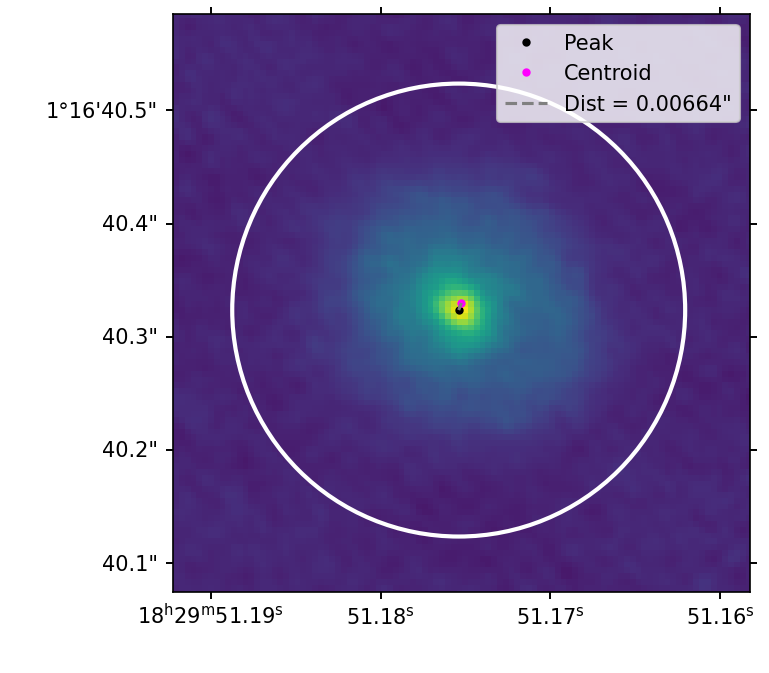

In [ ]:
fig  = plt.figure(figsize=(5,5), dpi=150)
gs = gridspec.GridSpec(figure=fig, nrows=1, ncols=1)
ax = fig.add_subplot(gs[0,0], projection = WCS(header_alma).celestial)
ax.set_xlim(alma_ap_centroid_ra-50, alma_ap_centroid_ra+50)
ax.set_ylim(alma_ap_centroid_dec-50, alma_ap_centroid_dec+50)
ax.imshow(data_alma)
ap_plot = alma_ap.to_pixel(WCS(header_alma).celestial)
ap_plot.plot(ax=ax, color='white', lw=2)
ax.plot(ContPeak_ra, ContPeak_dec, color='k', marker='o', ms=3, ls='', label='Peak')
ax.plot(alma_ap_centroid_ra, alma_ap_centroid_dec, color='magenta', marker='o', ls='', ms=3, label='Centroid')
ax.plot((ContPeak_ra[0], alma_ap_centroid_ra), (ContPeak_dec[0], alma_ap_centroid_dec), color='gray', ls='--', label='Dist = '+str(round(dist_alma_peak_cent_as,5))+'"')

#ax.contour(data_alma, levels=np.array([1,2,4,8])*2.8e-4, colors='gray', lw=1, alpha=0.7)
ax.set_xlabel(' ')
ax.set_ylabel(' ')
ax.legend(loc='upper right')
#plt.savefig(dfig+'NewALMA_CentroidPosition_v5_PositionAccuracy.png', dpi=150, bbox_inches='tight')

## MIRI

### ALMA Cont Centroid & MIRI CH4 mom0 Centroid

Set DATE-AVG to '2024-05-10T00:39:09.115' from MJD-AVG.
Set DATE-END to '2024-05-10T00:50:18.582' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -24.749973 from OBSGEO-[XYZ].
Set OBSGEO-H to 1591175987.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-05-10T01:06:35.437' from MJD-AVG.
Set DATE-END to '2024-05-10T01:16:43.156' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -24.759591 from OBSGEO-[XYZ].
Set OBSGEO-H to 1591322998.701 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-05-10T01:33:39.564' from MJD-AVG.
Set DATE-END to '2024-05-10T01:43:49.395' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -24.768795 from OBSGEO-[XYZ].
Set OBSGEO-H to 1591463749.682 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


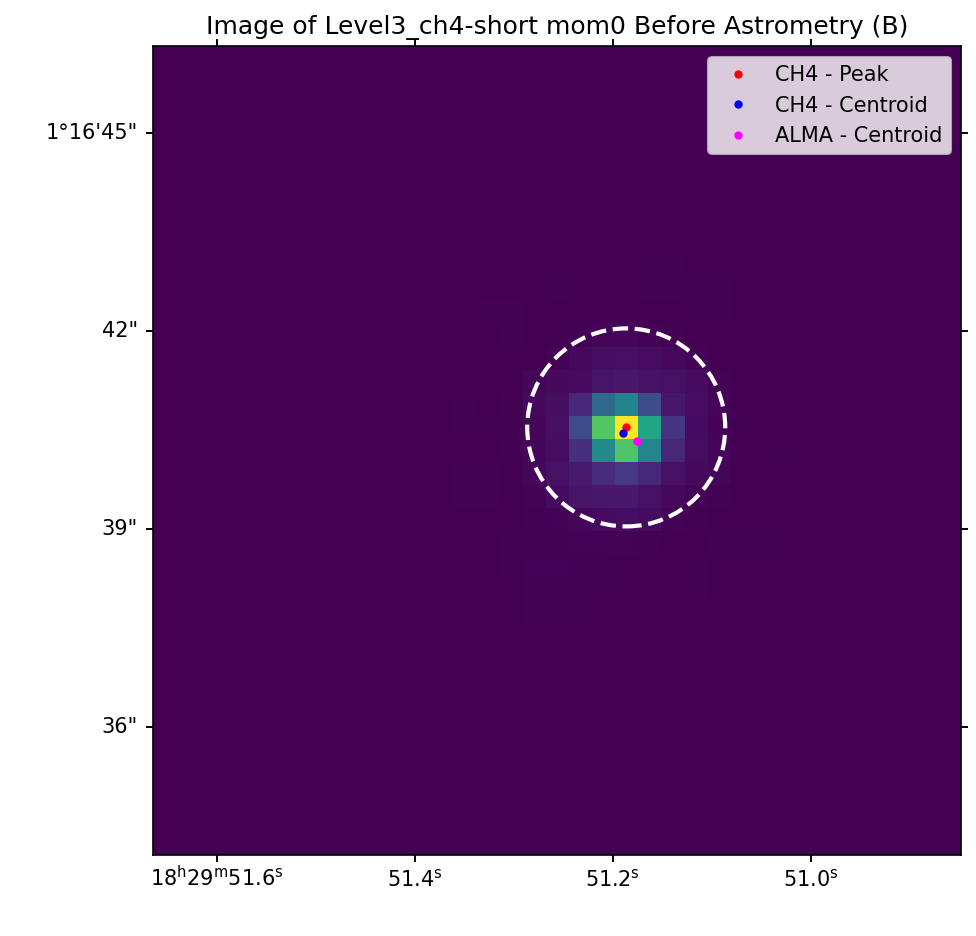

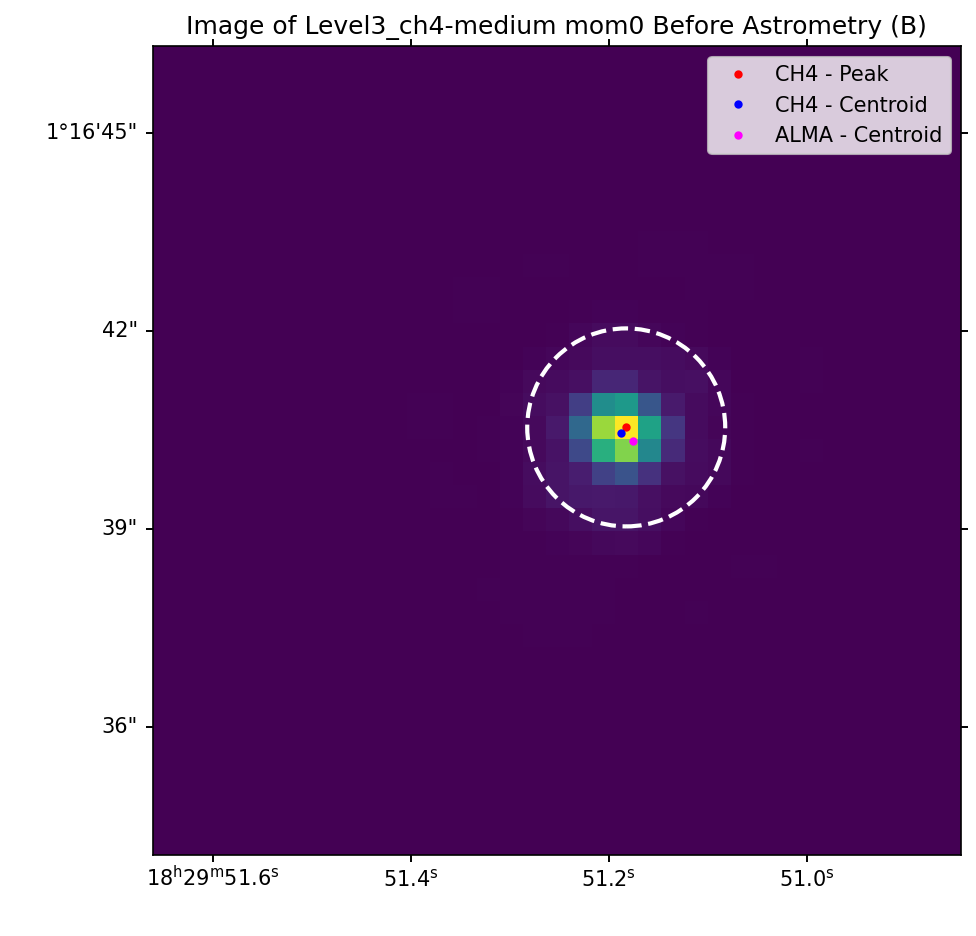

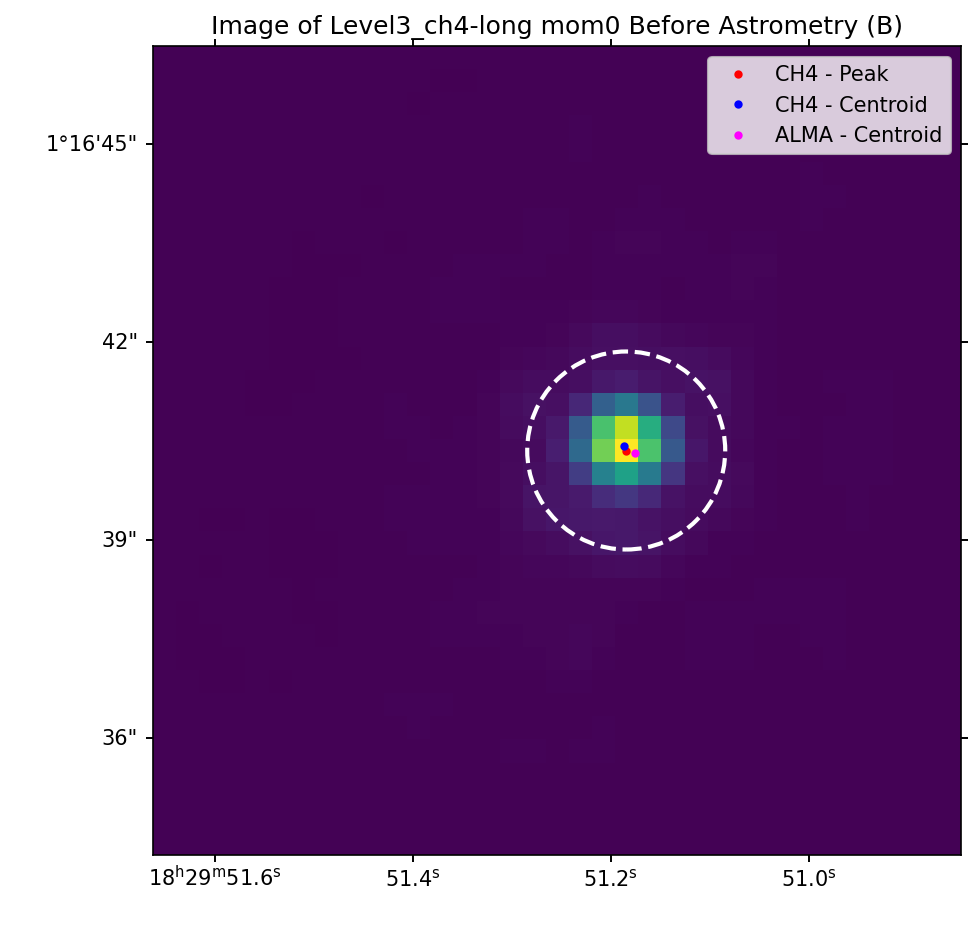

In [ ]:
dmiri_B = '/dataPath/'
dmiri_B_mom0 = '/dataPath/moment/'
mr_ch4_B = ['Level3_ch4-short_s3d.fits', 'Level3_ch4-medium_s3d.fits', 'Level3_ch4-long_s3d.fits']
mr_ch4_B_mom0 = ['Level3_ch4-short_s3d_b_mom0.fits', 'Level3_ch4-medium_s3d_b_mom0.fits', 'Level3_ch4-long_s3d_b_mom0.fits']

for i in range(len(mr_ch4_B)):
    hdu_B_mr4 = fits.open(dmiri_B+mr_ch4_B[i])
    hinfo_B_mr4 = hdu_B_mr4[1].header ; hinfo_B_mr4_0 = hdu_B_mr4[0].header ; data_B_mr4 = hdu_B_mr4[1].data

    hdu_B_mr4_mom0 = fits.open(dmiri_B_mom0+mr_ch4_B_mom0[i])
    hinfo_B_mr4_mom0 = hdu_B_mr4_mom0[0].header ; data_B_mr4_mom0 = hdu_B_mr4_mom0[0].data

    w_mr4 = WCS(hinfo_B_mr4_mom0).celestial
    '''
    Centroid
    '''
    mr4_ap, mr4_ap_stats = Cent_ApStats(w_mr4, data_B_mr4_mom0, 1.5)
    mr4_ap_cent_deg = mr4_ap_stats.sky_centroid
    mr4_ap_centroid_ra = mr4_ap_stats.centroid[0] ; mr4_ap_centroid_dec = mr4_ap_stats.centroid[1]

    '''
    Peak
    '''
    mr4_peak = np.where(data_B_mr4_mom0 == np.nanmax(data_B_mr4_mom0))
    mr4_peak_ra, mr4_peak_dec = mr4_peak[1][0], mr4_peak[0][0]
    mr4_peak_coords_deg = w_mr4.pixel_to_world(mr4_peak_ra, mr4_peak_dec)



    fig  = plt.figure(figsize=(7,7), dpi=150)
    gs = gridspec.GridSpec(figure=fig, nrows=1, ncols=1)
    ax0 = fig.add_subplot(gs[0,0], projection = w_mr4)
    ax0.imshow(data_B_mr4_mom0)
    ap_plot0 = mr4_ap.to_pixel(w_mr4)
    ap_plot0.plot(ax=ax0, color='white', lw=2, ls='--')
    ax0.plot(mr4_peak_ra, mr4_peak_dec, color='r', marker='o', ls='', ms=3, label='CH4 - Peak')
    ax0.plot(mr4_ap_centroid_ra, mr4_ap_centroid_dec, color='b', marker='o',ls='', ms=3, label='CH4 - Centroid')
    Cent_mr4_alma_coords = w_mr4.world_to_pixel(alma_ap_cent_deg)
    ax0.plot(Cent_mr4_alma_coords[0], Cent_mr4_alma_coords[1], color='magenta', marker='o', ls='', ms=3, label='ALMA - Centroid')
    #rep_alma_cont_mr4 = MatchingCoor(data_alma, WCS(header_alma).celestial, data_B_mr4_22, w_mr4)
    #ax0.contour(rep_alma_cont_mr4, levels=np.array([1,2,4,8])*2.8e-4, colors='gray', lw=1, alpha=0.7)
    ax0.set_xlabel(' ')
    ax0.set_ylabel(' ')
    ax0.legend()
    ax0.set_title(r'Image of '+mr_ch4_B_mom0[i][:-16]+' mom0 Before Astrometry (B)')

    plt.savefig(dfig+mr_ch4_B_mom0[i][:-5]+'_Astrometry_v5_centroid_peak.png', dpi=150, bbox_inches='tight')

    del_ra_mr4_B = dms2deg(mr4_ap_cent_deg.ra - alma_ap_cent_deg.ra)
    del_dec_mr4_B = dms2deg(mr4_ap_cent_deg.dec - alma_ap_cent_deg.dec)

    hinfo_B_mr4_new = deepcopy(hinfo_B_mr4)
    hinfo_B_mr4_new['CRVAL1'] = hinfo_B_mr4_new['CRVAL1'] - del_ra_mr4_B
    hinfo_B_mr4_new['CRVAL2'] = hinfo_B_mr4_new['CRVAL2'] - del_dec_mr4_B
    fits.writeto(dmiri_B+'astrometry_v5/'+mr_ch4_B[i][:-5]+'_AstrometryV5_centroid.fits',  data_B_mr4, header=hinfo_B_mr4_0+hinfo_B_mr4_new, overwrite=True)# +

#### Checking after astrometry - CH4

Set DATE-AVG to '2024-05-10T00:39:09.115' from MJD-AVG'. [astropy.wcs.wcs]
Set OBSGEO-B to   -24.749973 from OBSGEO-[XYZ].
Set OBSGEO-H to 1591175987.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-05-10T01:06:35.437' from MJD-AVG'. [astropy.wcs.wcs]
Set OBSGEO-B to   -24.759591 from OBSGEO-[XYZ].
Set OBSGEO-H to 1591322998.701 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-05-10T01:33:39.564' from MJD-AVG'. [astropy.wcs.wcs]
Set OBSGEO-B to   -24.768795 from OBSGEO-[XYZ].
Set OBSGEO-H to 1591463749.682 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


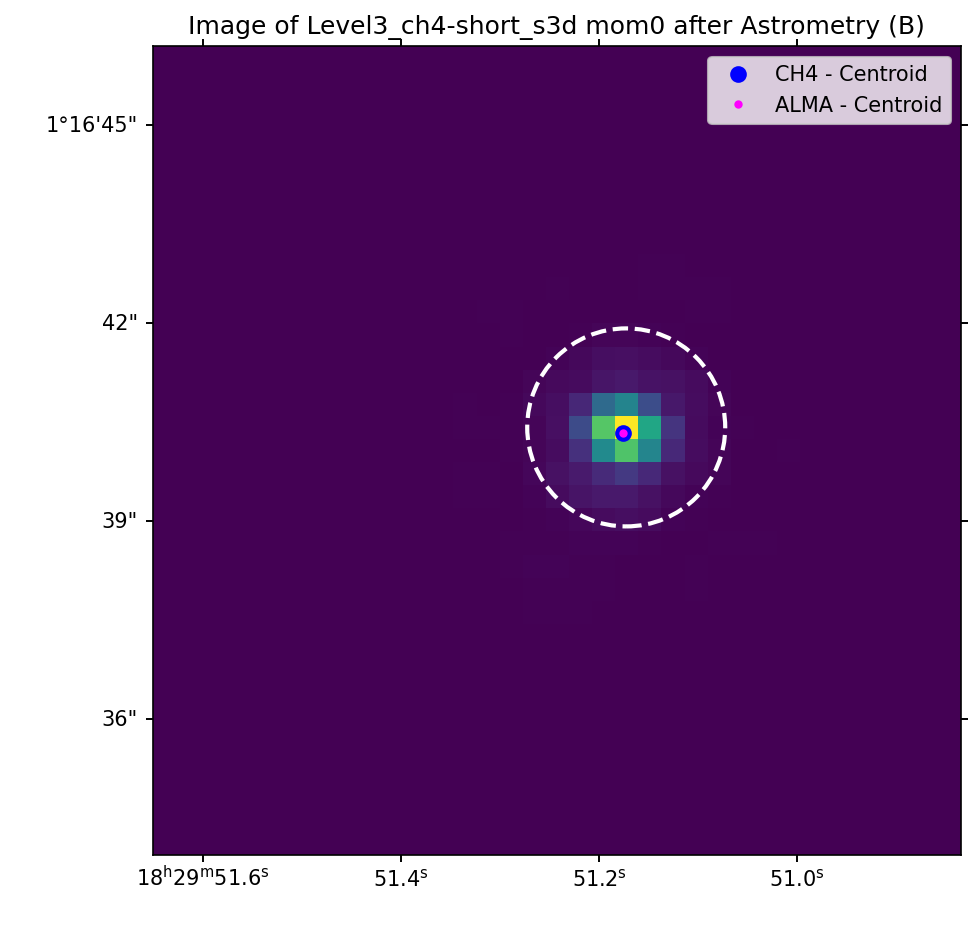

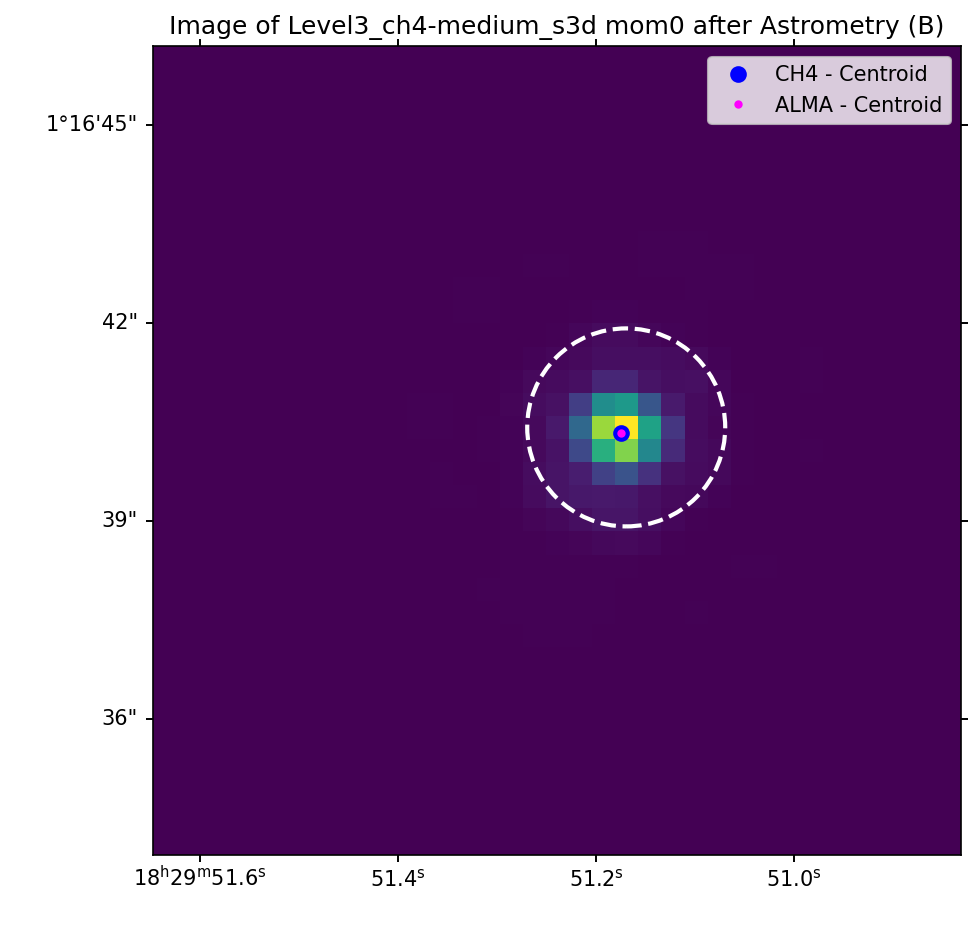

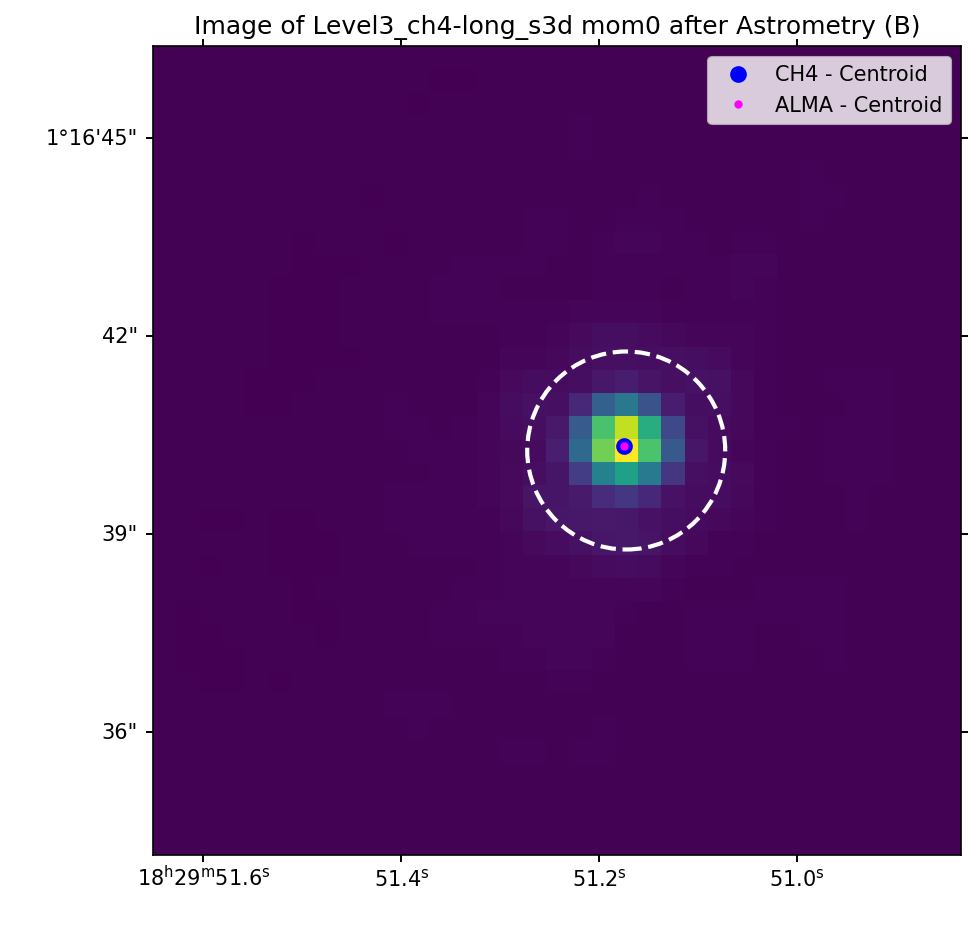

In [ ]:
dmiri_B_mom0_astrometry = '/dataPath/'
mr_ch4_B_mom0_astrometry = ['Level3_ch4-short_s3d_AstrometryV5_centroid_b_mom0.fits', 'Level3_ch4-medium_s3d_AstrometryV5_centroid_b_mom0.fits', 'Level3_ch4-long_s3d_AstrometryV5_centroid_b_mom0.fits']

for i in range(len(mr_ch4_B)):
    hdu_B_mr4_mom0 = fits.open(dmiri_B_mom0_astrometry+mr_ch4_B_mom0_astrometry[i])
    hinfo_B_mr4_mom0 = hdu_B_mr4_mom0[0].header ; data_B_mr4_mom0 = hdu_B_mr4_mom0[0].data

    w_mr4 = WCS(hinfo_B_mr4_mom0).celestial
    '''
    Centroid
    '''
    mr4_ap, mr4_ap_stats = Cent_ApStats(w_mr4, data_B_mr4_mom0, 1.5)
    mr4_ap_cent_deg = mr4_ap_stats.sky_centroid
    mr4_ap_centroid_ra = mr4_ap_stats.centroid[0] ; mr4_ap_centroid_dec = mr4_ap_stats.centroid[1]

    '''
    Peak
    '''
    mr4_peak = np.where(data_B_mr4_mom0 == np.nanmax(data_B_mr4_mom0))
    mr4_peak_ra, mr4_peak_dec = mr4_peak[1][0], mr4_peak[0][0]
    mr4_peak_coords_deg = w_mr4.pixel_to_world(mr4_peak_ra, mr4_peak_dec)



    fig  = plt.figure(figsize=(7,7), dpi=150)
    gs = gridspec.GridSpec(figure=fig, nrows=1, ncols=1)
    ax0 = fig.add_subplot(gs[0,0], projection = w_mr4)
    ax0.imshow(data_B_mr4_mom0)
    ap_plot0 = mr4_ap.to_pixel(w_mr4)
    ap_plot0.plot(ax=ax0, color='white', lw=2, ls='--')
    ax0.plot(mr4_ap_centroid_ra, mr4_ap_centroid_dec, color='b', marker='o',ls='', ms=7, label='CH4 - Centroid')
    Cent_mr4_alma_coords = w_mr4.world_to_pixel(alma_ap_cent_deg)
    ax0.plot(Cent_mr4_alma_coords[0], Cent_mr4_alma_coords[1], color='magenta', marker='o', ls='', ms=3, label='ALMA - Centroid')
    #rep_alma_cont_mr4 = MatchingCoor(data_alma, WCS(header_alma).celestial, data_B_mr4_22, w_mr4)
    #ax0.contour(rep_alma_cont_mr4, levels=np.array([1,2,4,8])*2.8e-4, colors='gray', lw=1, alpha=0.7)
    ax0.set_xlabel(' ')
    ax0.set_ylabel(' ')
    ax0.legend()
    ax0.set_title(r'Image of '+mr_ch4_B_mom0_astrometry[i][:-34]+' mom0 after Astrometry (B)')

    #plt.savefig(dfig+mr_ch4_B_mom0[i][:-5]+'prf__Astrometry_v5_after.png', dpi=150, bbox_inches='tight')

### ALMA Cont Centroid & MIRI CH3 mom0 Centroid

Set DATE-AVG to '2024-05-10T00:39:09.115' from MJD-AVG.
Set DATE-END to '2024-05-10T00:50:18.582' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -24.749973 from OBSGEO-[XYZ].
Set OBSGEO-H to 1591175987.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-05-10T01:06:35.437' from MJD-AVG.
Set DATE-END to '2024-05-10T01:16:43.156' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -24.759591 from OBSGEO-[XYZ].
Set OBSGEO-H to 1591322998.701 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-05-10T01:33:39.564' from MJD-AVG.
Set DATE-END to '2024-05-10T01:43:49.395' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -24.768795 from OBSGEO-[XYZ].
Set OBSGEO-H to 1591463749.682 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


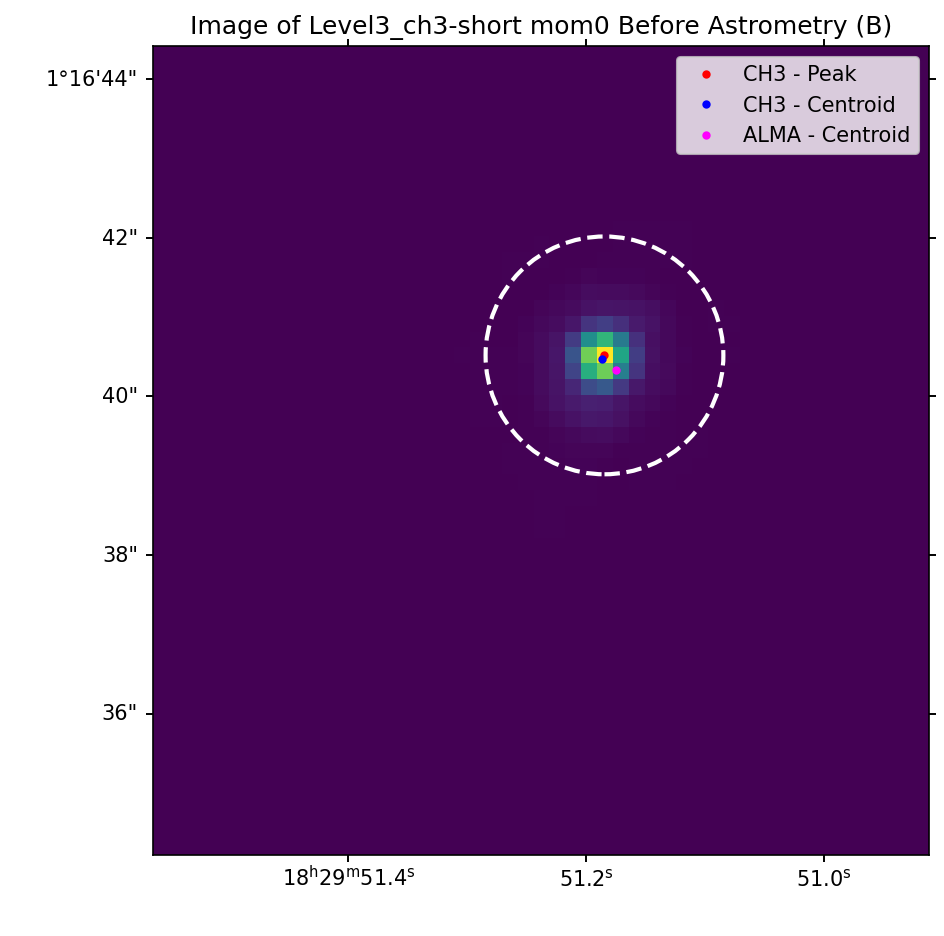

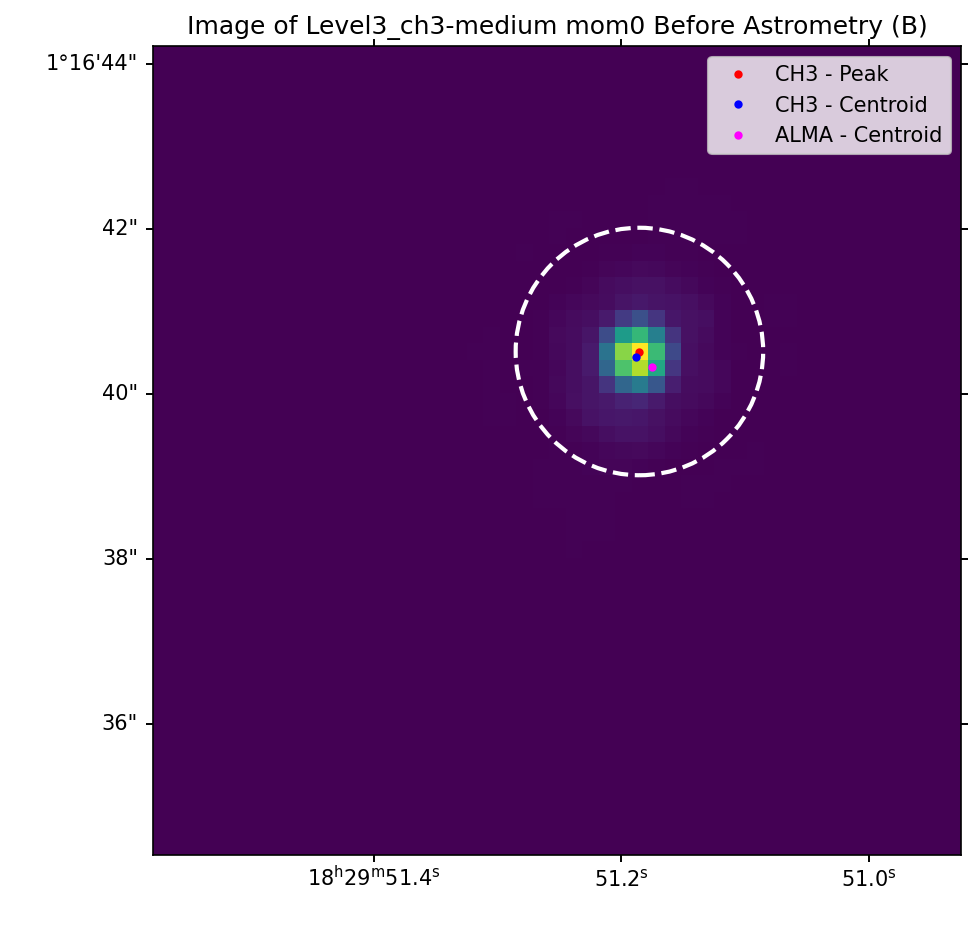

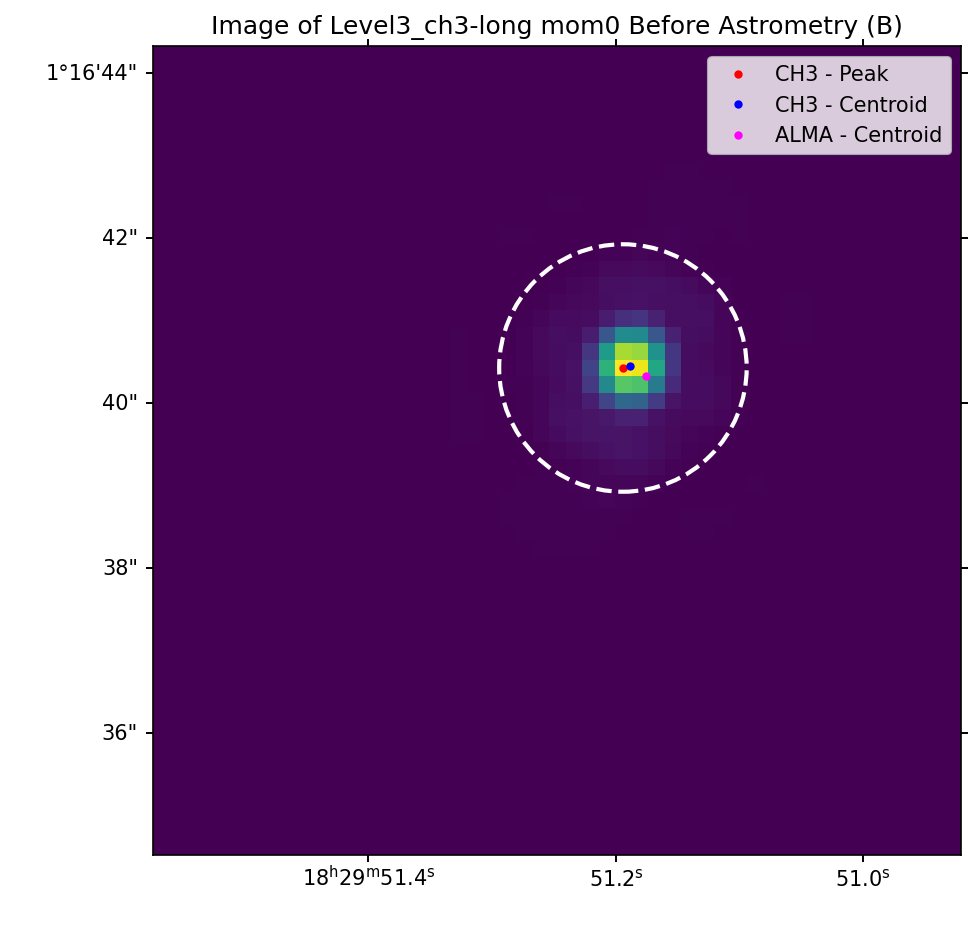

In [ ]:
mr_ch3_B = ['Level3_ch3-short_s3d.fits', 'Level3_ch3-medium_s3d.fits', 'Level3_ch3-long_s3d.fits']
mr_ch3_B_mom0 = ['Level3_ch3-short_s3d_b_mom0.fits', 'Level3_ch3-medium_s3d_b_mom0.fits', 'Level3_ch3-long_s3d_b_mom0.fits']

for i in range(len(mr_ch3_B)):
    hdu_B_mr3 = fits.open(dmiri_B+mr_ch3_B[i])
    hinfo_B_mr3 = hdu_B_mr3[1].header ; hinfo_B_mr3_0 = hdu_B_mr3[0].header ; data_B_mr3 = hdu_B_mr3[1].data

    hdu_B_mr3_mom0 = fits.open(dmiri_B_mom0+mr_ch3_B_mom0[i])
    hinfo_B_mr3_mom0 = hdu_B_mr3_mom0[0].header ; data_B_mr3_mom0 = hdu_B_mr3_mom0[0].data

    w_mr3 = WCS(hinfo_B_mr3_mom0).celestial
    '''
    Centroid
    '''
    mr3_ap, mr3_ap_stats = Cent_ApStats(w_mr3, data_B_mr3_mom0, 1.5)
    mr3_ap_cent_deg = mr3_ap_stats.sky_centroid
    mr3_ap_centroid_ra = mr3_ap_stats.centroid[0] ; mr3_ap_centroid_dec = mr3_ap_stats.centroid[1]

    '''
    Peak
    '''
    mr3_peak = np.where(data_B_mr3_mom0 == np.nanmax(data_B_mr3_mom0))
    mr3_peak_ra, mr3_peak_dec = mr3_peak[1][0], mr3_peak[0][0]
    mr3_peak_coords_deg = w_mr3.pixel_to_world(mr3_peak_ra, mr3_peak_dec)



    fig  = plt.figure(figsize=(7,7), dpi=150)
    gs = gridspec.GridSpec(figure=fig, nrows=1, ncols=1)
    ax0 = fig.add_subplot(gs[0,0], projection = w_mr3)
    ax0.imshow(data_B_mr3_mom0)
    ap_plot0 = mr3_ap.to_pixel(w_mr3)
    ap_plot0.plot(ax=ax0, color='white', lw=2, ls='--')
    ax0.plot(mr3_peak_ra, mr3_peak_dec, color='r', marker='o', ls='', ms=3, label='CH3 - Peak')
    ax0.plot(mr3_ap_centroid_ra, mr3_ap_centroid_dec, color='b', marker='o',ls='', ms=3, label='CH3 - Centroid')
    Cent_mr3_alma_coords = w_mr3.world_to_pixel(alma_ap_cent_deg)
    ax0.plot(Cent_mr3_alma_coords[0], Cent_mr3_alma_coords[1], color='magenta', marker='o', ls='', ms=3, label='ALMA - Centroid')
    ax0.set_xlabel(' ')
    ax0.set_ylabel(' ')
    ax0.legend()
    ax0.set_title(r'Image of '+mr_ch3_B_mom0[i][:-16]+' mom0 Before Astrometry (B)')

    #plt.savefig(dfig+mr_ch3_B_mom0[i][:-5]+'_Astrometry_v5_centroid_peak.png', dpi=150, bbox_inches='tight')

    del_ra_mr3_B = dms2deg(mr3_ap_cent_deg.ra - alma_ap_cent_deg.ra)
    del_dec_mr3_B = dms2deg(mr3_ap_cent_deg.dec - alma_ap_cent_deg.dec)

    hinfo_B_mr3_new = deepcopy(hinfo_B_mr3)
    hinfo_B_mr3_new['CRVAL1'] = hinfo_B_mr3_new['CRVAL1'] - del_ra_mr3_B
    hinfo_B_mr3_new['CRVAL2'] = hinfo_B_mr3_new['CRVAL2'] - del_dec_mr3_B
    fits.writeto(dmiri_B+'astrometry_v5/'+mr_ch3_B[i][:-5]+'_AstrometryV5_centroid.fits',  data_B_mr3, header=hinfo_B_mr3_0+hinfo_B_mr3_new, overwrite=True)#

#### Checking after astrometry - CH3

Set DATE-AVG to '2024-05-10T00:39:09.115' from MJD-AVG'. [astropy.wcs.wcs]
Set OBSGEO-B to   -24.749973 from OBSGEO-[XYZ].
Set OBSGEO-H to 1591175987.444 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-05-10T01:06:35.437' from MJD-AVG'. [astropy.wcs.wcs]
Set OBSGEO-B to   -24.759591 from OBSGEO-[XYZ].
Set OBSGEO-H to 1591322998.701 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-05-10T01:33:39.564' from MJD-AVG'. [astropy.wcs.wcs]
Set OBSGEO-B to   -24.768795 from OBSGEO-[XYZ].
Set OBSGEO-H to 1591463749.682 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


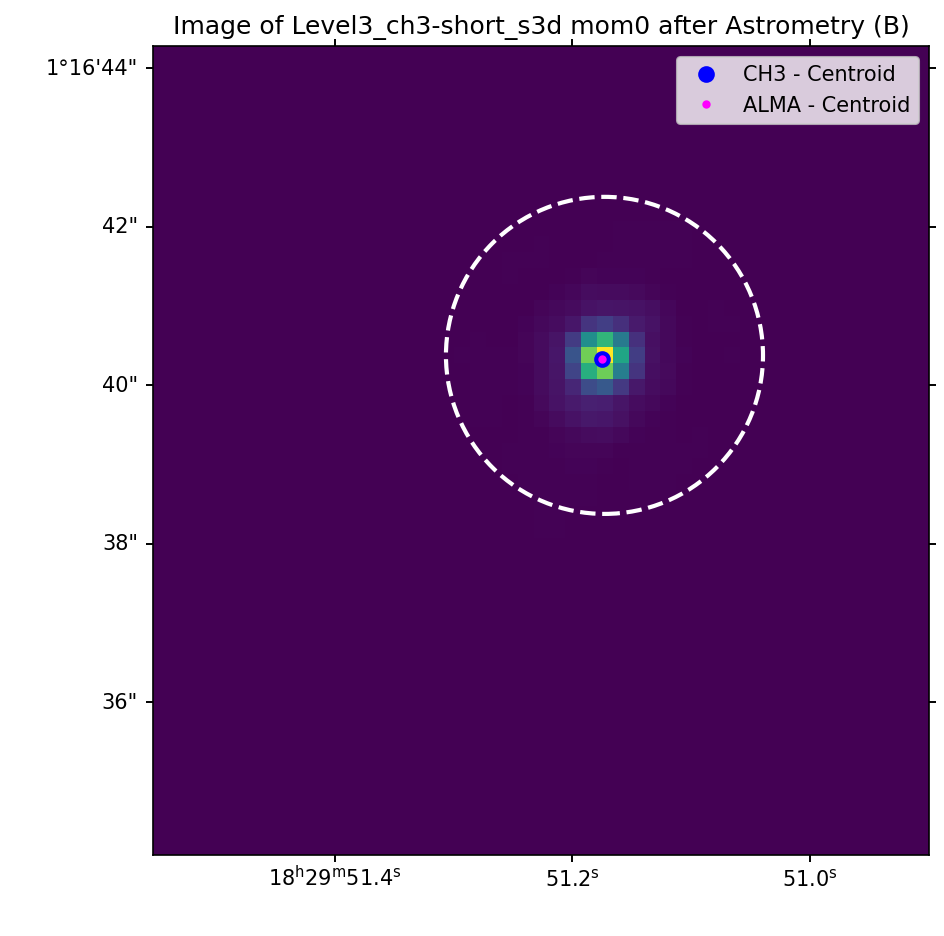

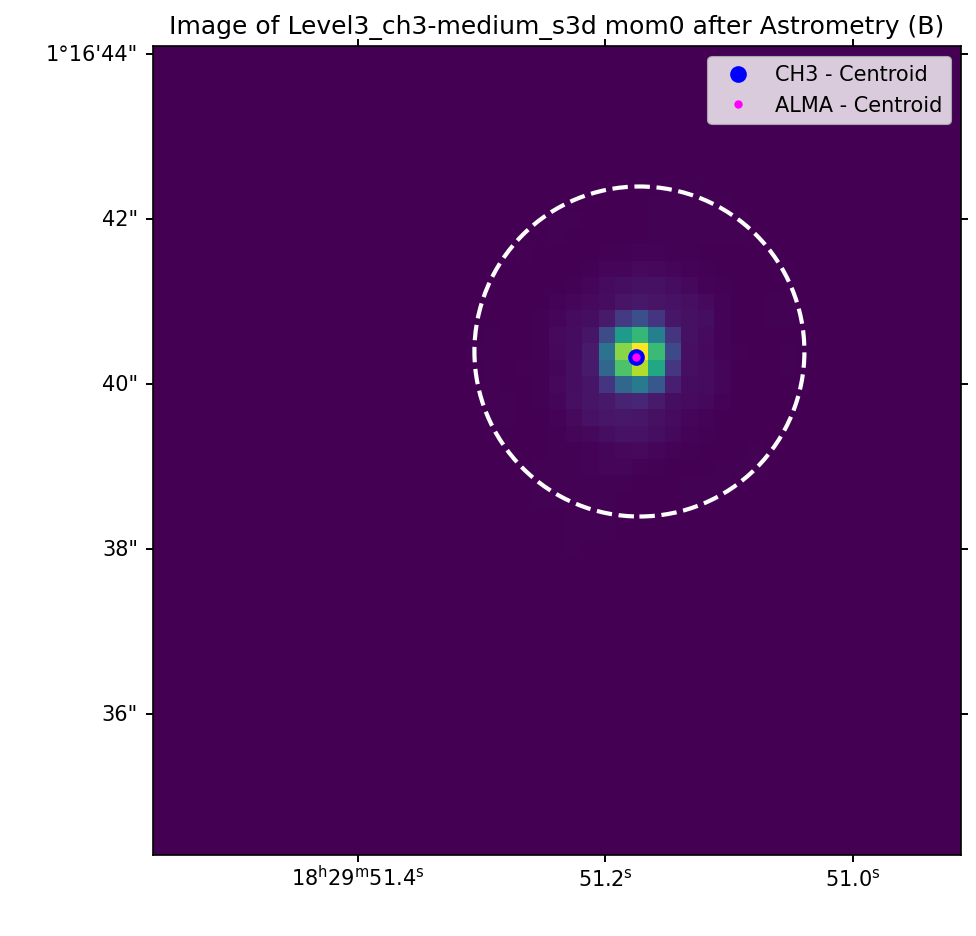

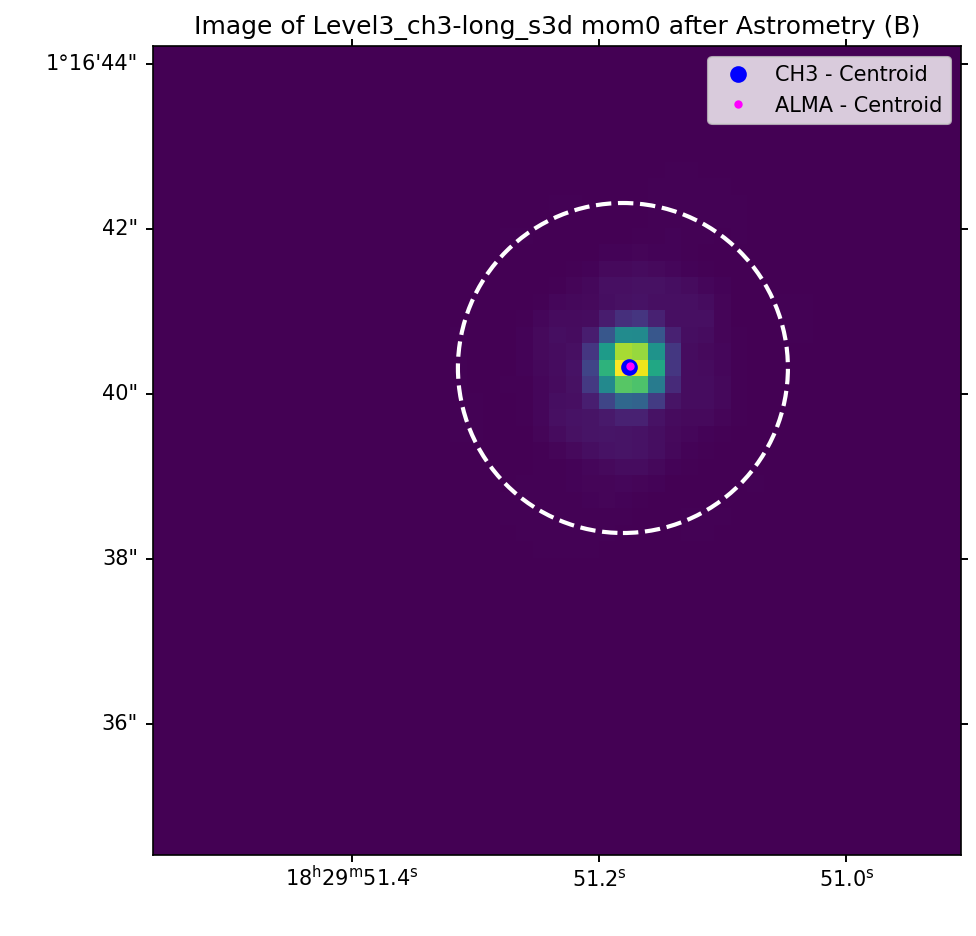

In [ ]:
mr_ch3_B_mom0_astrometry = ['Level3_ch3-short_s3d_AstrometryV5_centroid_b_mom0.fits', 'Level3_ch3-medium_s3d_AstrometryV5_centroid_b_mom0.fits', 'Level3_ch3-long_s3d_AstrometryV5_centroid_b_mom0.fits']

for i in range(len(mr_ch3_B)):
    hdu_B_mr3_mom0 = fits.open(dmiri_B_mom0_astrometry+mr_ch3_B_mom0_astrometry[i])
    hinfo_B_mr3_mom0 = hdu_B_mr3_mom0[0].header ; data_B_mr3_mom0 = hdu_B_mr3_mom0[0].data

    w_mr3 = WCS(hinfo_B_mr3_mom0).celestial
    '''
    Centroid
    '''
    mr3_ap, mr3_ap_stats = Cent_ApStats(w_mr3, data_B_mr3_mom0, 2)
    mr3_ap_cent_deg = mr3_ap_stats.sky_centroid
    mr3_ap_centroid_ra = mr3_ap_stats.centroid[0] ; mr3_ap_centroid_dec = mr3_ap_stats.centroid[1]

    '''
    Peak
    '''
    mr3_peak = np.where(data_B_mr3_mom0 == np.nanmax(data_B_mr3_mom0))
    mr3_peak_ra, mr3_peak_dec = mr3_peak[1][0], mr3_peak[0][0]
    mr3_peak_coords_deg = w_mr3.pixel_to_world(mr3_peak_ra, mr3_peak_dec)



    fig  = plt.figure(figsize=(7,7), dpi=150)
    gs = gridspec.GridSpec(figure=fig, nrows=1, ncols=1)
    ax0 = fig.add_subplot(gs[0,0], projection = w_mr3)
    ax0.imshow(data_B_mr3_mom0)
    ap_plot0 = mr3_ap.to_pixel(w_mr3)
    ap_plot0.plot(ax=ax0, color='white', lw=2, ls='--')
    ax0.plot(mr3_ap_centroid_ra, mr3_ap_centroid_dec, color='b', marker='o',ls='', ms=7, label='CH3 - Centroid')
    Cent_mr3_alma_coords = w_mr3.world_to_pixel(alma_ap_cent_deg)
    ax0.plot(Cent_mr3_alma_coords[0], Cent_mr3_alma_coords[1], color='magenta', marker='o', ls='', ms=3, label='ALMA - Centroid')
    ax0.set_xlabel(' ')
    ax0.set_ylabel(' ')
    ax0.legend()
    ax0.set_title(r'Image of '+mr_ch3_B_mom0_astrometry[i][:-34]+' mom0 after Astrometry (B)')

    #plt.savefig(dfig+mr_ch3_B_mom0[i][:-5]+'_prf_Astrometry_v5_after.png', dpi=150, bbox_inches='tight')

### ALMA Cont Centroid & MIRI CH2 mom0 Centroid

Set DATE-AVG to '2024-05-10T00:39:07.915' from MJD-AVG.
Set DATE-END to '2024-05-10T00:50:17.430' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -24.749966 from OBSGEO-[XYZ].
Set OBSGEO-H to 1591175882.015 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-05-10T01:06:37.021' from MJD-AVG.
Set DATE-END to '2024-05-10T01:16:44.756' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -24.759599 from OBSGEO-[XYZ].
Set OBSGEO-H to 1591323131.874 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-05-10T01:33:38.396' from MJD-AVG.
Set DATE-END to '2024-05-10T01:43:48.243' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -24.768788 from OBSGEO-[XYZ].
Set OBSGEO-H to 1591463644.255 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


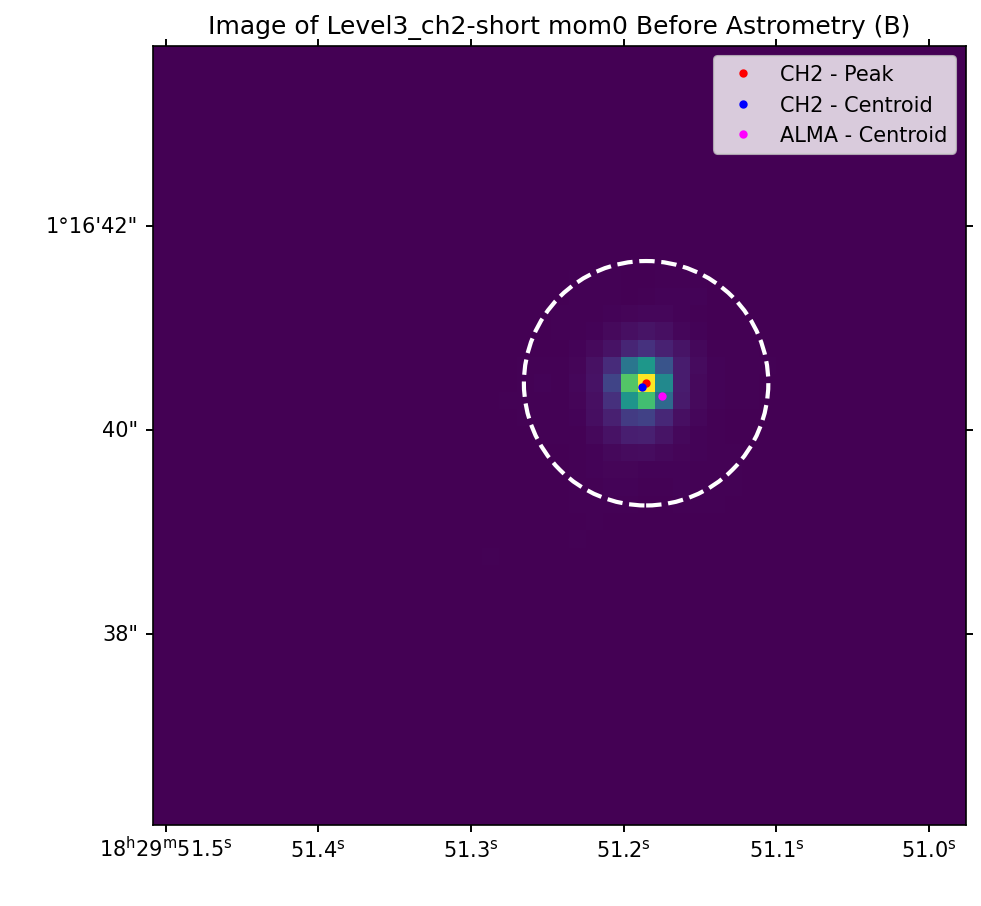

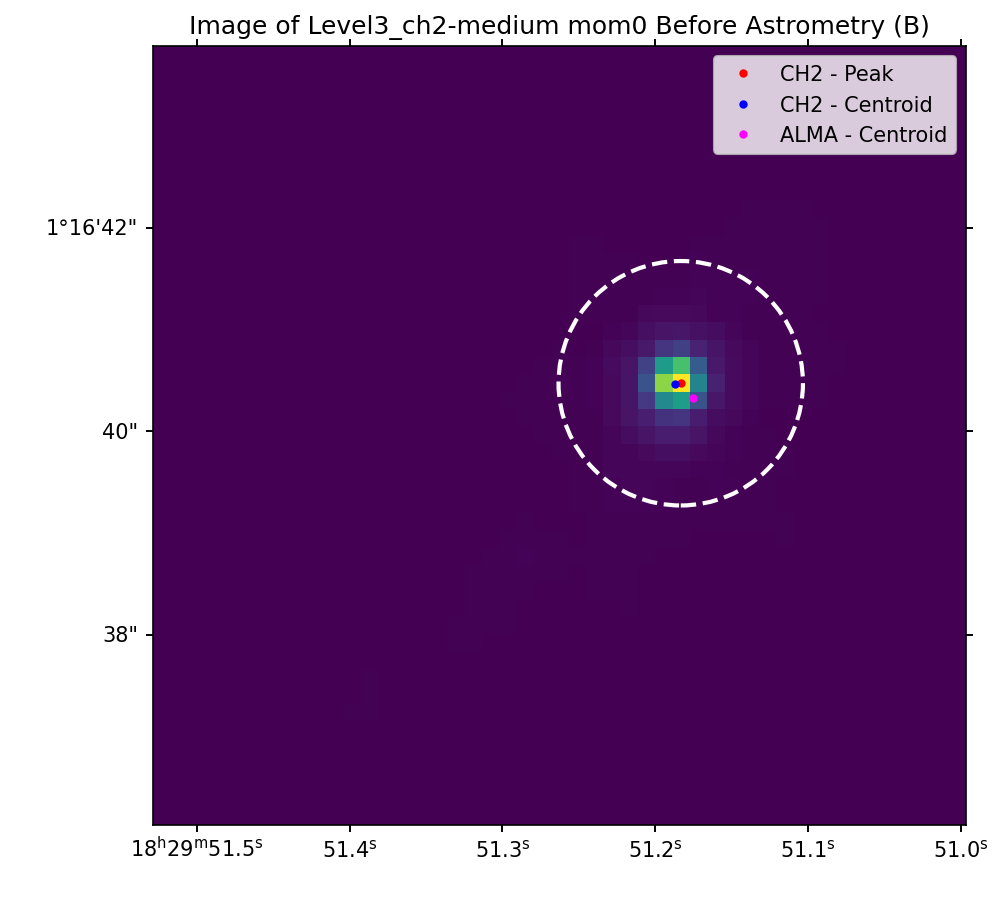

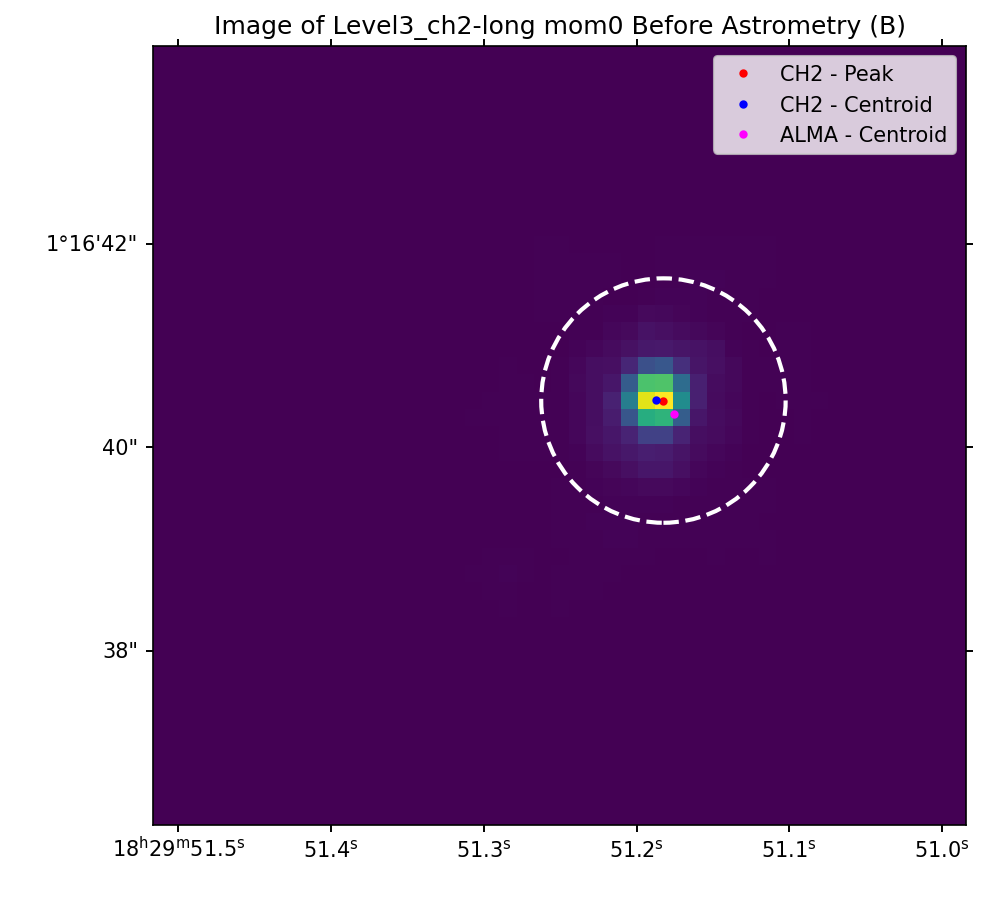

In [ ]:
mr_ch2_B = ['Level3_ch2-short_s3d.fits', 'Level3_ch2-medium_s3d.fits', 'Level3_ch2-long_s3d.fits']
mr_ch2_B_mom0 = ['Level3_ch2-short_s3d_b_mom0.fits', 'Level3_ch2-medium_s3d_b_mom0.fits', 'Level3_ch2-long_s3d_b_mom0.fits']

for i in range(len(mr_ch2_B)):
    hdu_B_mr2 = fits.open(dmiri_B+mr_ch2_B[i])
    hinfo_B_mr2 = hdu_B_mr2[1].header ; hinfo_B_mr2_0 = hdu_B_mr2[0].header ; data_B_mr2 = hdu_B_mr2[1].data

    hdu_B_mr2_mom0 = fits.open(dmiri_B_mom0+mr_ch2_B_mom0[i])
    hinfo_B_mr2_mom0 = hdu_B_mr2_mom0[0].header ; data_B_mr2_mom0 = hdu_B_mr2_mom0[0].data

    w_mr2 = WCS(hinfo_B_mr2_mom0).celestial
    '''
    Centroid
    '''
    mr2_ap, mr2_ap_stats = Cent_ApStats(w_mr2, data_B_mr2_mom0, 1.2)
    mr2_ap_cent_deg = mr2_ap_stats.sky_centroid
    mr2_ap_centroid_ra = mr2_ap_stats.centroid[0] ; mr2_ap_centroid_dec = mr2_ap_stats.centroid[1]

    '''
    Peak
    '''
    mr2_peak = np.where(data_B_mr2_mom0 == np.nanmax(data_B_mr2_mom0))
    mr2_peak_ra, mr2_peak_dec = mr2_peak[1][0], mr2_peak[0][0]
    mr2_peak_coords_deg = w_mr2.pixel_to_world(mr2_peak_ra, mr2_peak_dec)



    fig  = plt.figure(figsize=(7,7), dpi=150)
    gs = gridspec.GridSpec(figure=fig, nrows=1, ncols=1)
    ax0 = fig.add_subplot(gs[0,0], projection = w_mr2)
    ax0.imshow(data_B_mr2_mom0)
    ap_plot0 = mr2_ap.to_pixel(w_mr2)
    ap_plot0.plot(ax=ax0, color='white', lw=2, ls='--')
    ax0.plot(mr2_peak_ra, mr2_peak_dec, color='r', marker='o', ls='', ms=3, label='CH2 - Peak')
    ax0.plot(mr2_ap_centroid_ra, mr2_ap_centroid_dec, color='b', marker='o',ls='', ms=3, label='CH2 - Centroid')
    Cent_mr2_alma_coords = w_mr2.world_to_pixel(alma_ap_cent_deg)
    ax0.plot(Cent_mr2_alma_coords[0], Cent_mr2_alma_coords[1], color='magenta', marker='o', ls='', ms=3, label='ALMA - Centroid')
    ax0.set_xlabel(' ')
    ax0.set_ylabel(' ')
    ax0.legend()
    ax0.set_title(r'Image of '+mr_ch2_B_mom0[i][:-16]+' mom0 Before Astrometry (B)')

    #plt.savefig(dfig+mr_ch2_B_mom0[i][:-5]+'_prf_Astrometry_v5_centroid_peak.png', dpi=150, bbox_inches='tight')

    del_ra_mr2_B = dms2deg(mr2_ap_cent_deg.ra - alma_ap_cent_deg.ra)
    del_dec_mr2_B = dms2deg(mr2_ap_cent_deg.dec - alma_ap_cent_deg.dec)

    hinfo_B_mr2_new = deepcopy(hinfo_B_mr2)
    hinfo_B_mr2_new['CRVAL1'] = hinfo_B_mr2_new['CRVAL1'] - del_ra_mr2_B
    hinfo_B_mr2_new['CRVAL2'] = hinfo_B_mr2_new['CRVAL2'] - del_dec_mr2_B
    fits.writeto(dmiri_B+'astrometry_v5/'+mr_ch2_B[i][:-5]+'_AstrometryV5_centroid.fits',  data_B_mr2, header=hinfo_B_mr2_0+hinfo_B_mr2_new, overwrite=True)#

#### Checking after astrometry - CH2

Set DATE-AVG to '2024-05-10T00:39:07.915' from MJD-AVG'. [astropy.wcs.wcs]
Set OBSGEO-B to   -24.749966 from OBSGEO-[XYZ].
Set OBSGEO-H to 1591175882.015 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-05-10T01:06:37.021' from MJD-AVG'. [astropy.wcs.wcs]
Set OBSGEO-B to   -24.759599 from OBSGEO-[XYZ].
Set OBSGEO-H to 1591323131.874 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-05-10T01:33:38.396' from MJD-AVG'. [astropy.wcs.wcs]
Set OBSGEO-B to   -24.768788 from OBSGEO-[XYZ].
Set OBSGEO-H to 1591463644.255 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


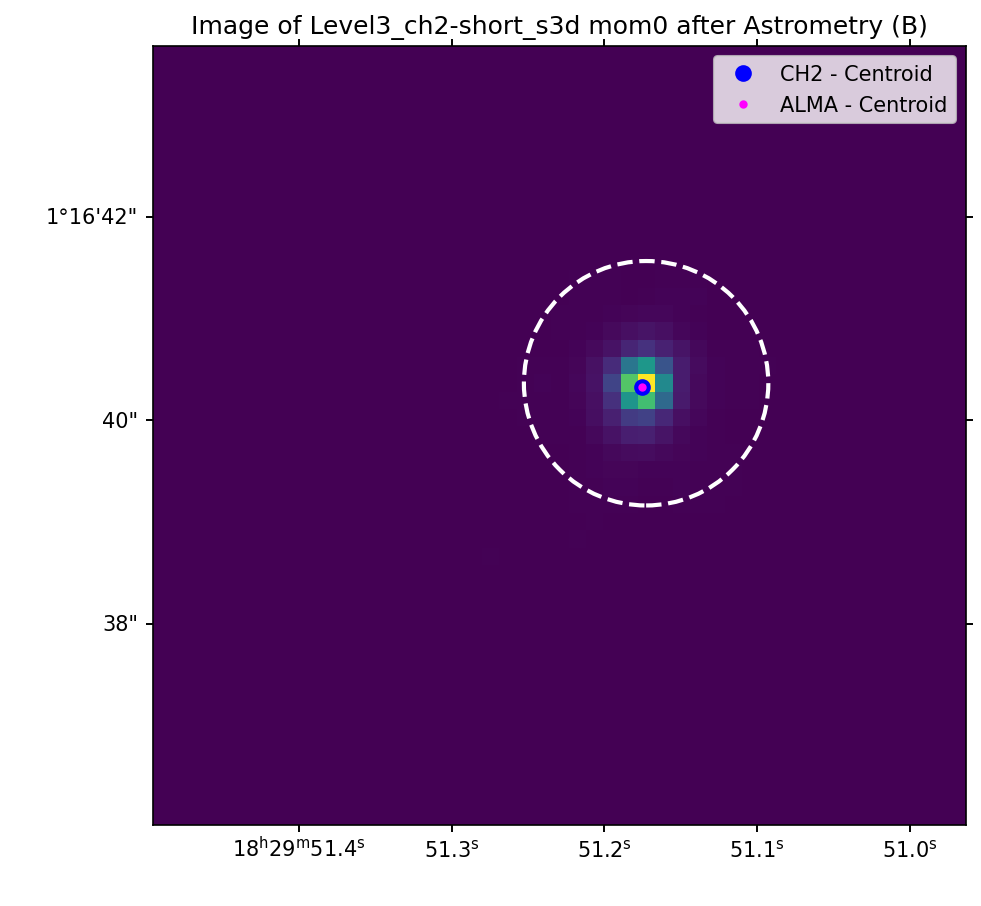

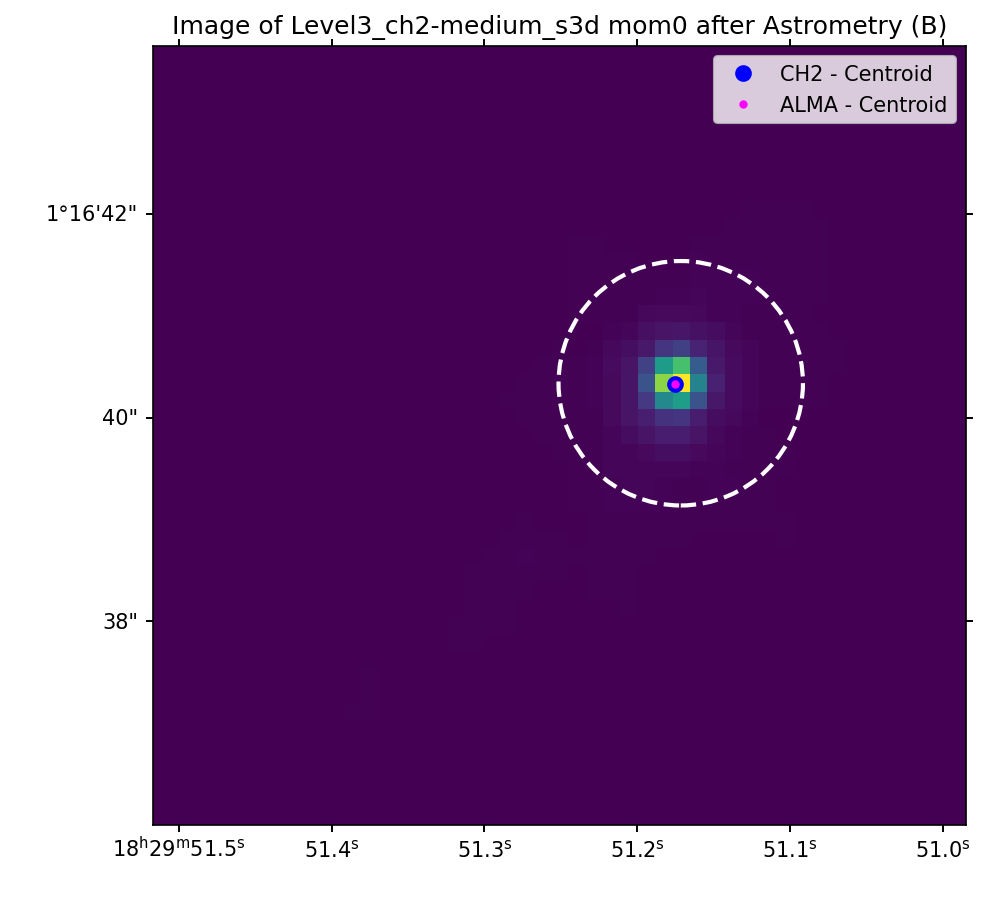

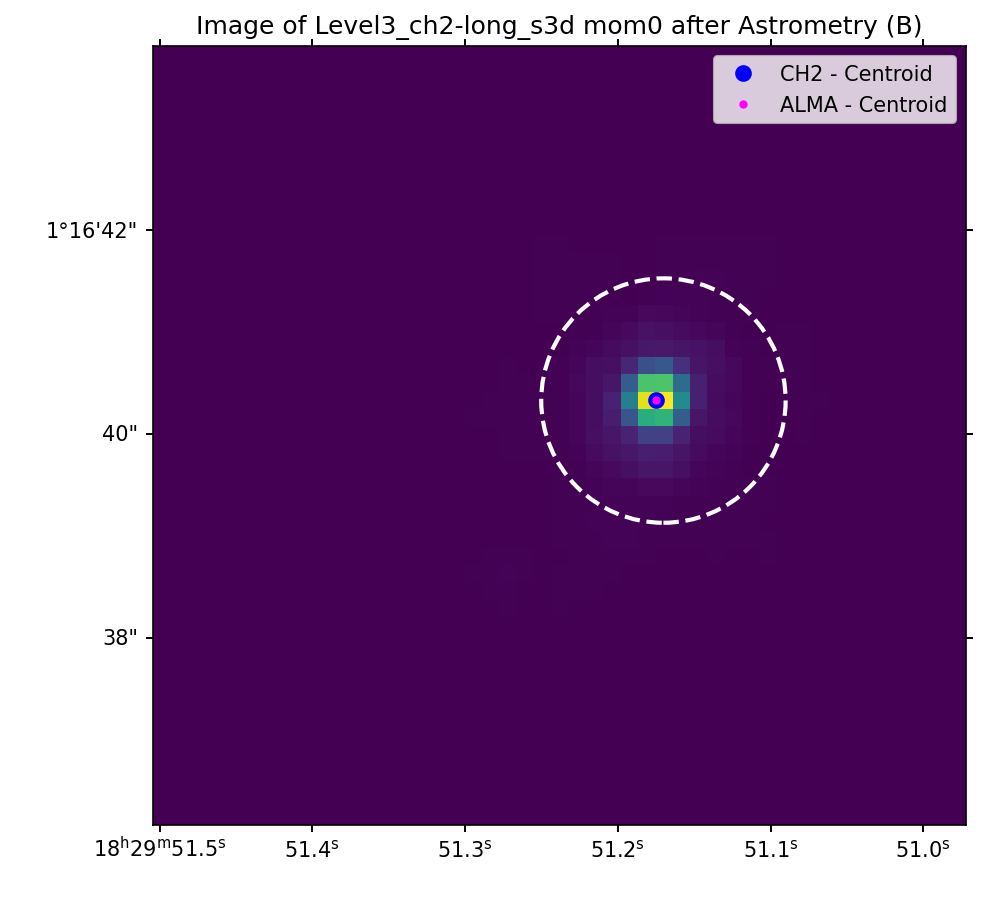

In [ ]:
#dmiri_B_mom0_astrometry = '/home/chkim/work/MIRI/Burst/Source/stage3/astrometry_v5/moment/'
mr_ch2_B_mom0_astrometry = ['Level3_ch2-short_s3d_AstrometryV5_centroid_b_mom0.fits', 'Level3_ch2-medium_s3d_AstrometryV5_centroid_b_mom0.fits', 'Level3_ch2-long_s3d_AstrometryV5_centroid_b_mom0.fits']

for i in range(len(mr_ch2_B)):
    hdu_B_mr2_mom0 = fits.open(dmiri_B_mom0_astrometry+mr_ch2_B_mom0_astrometry[i])
    hinfo_B_mr2_mom0 = hdu_B_mr2_mom0[0].header ; data_B_mr2_mom0 = hdu_B_mr2_mom0[0].data

    w_mr2 = WCS(hinfo_B_mr2_mom0).celestial
    '''
    Centroid
    '''
    mr2_ap, mr2_ap_stats = Cent_ApStats(w_mr2, data_B_mr2_mom0, 1.2)
    mr2_ap_cent_deg = mr2_ap_stats.sky_centroid
    mr2_ap_centroid_ra = mr2_ap_stats.centroid[0] ; mr2_ap_centroid_dec = mr2_ap_stats.centroid[1]

    '''
    Peak
    '''
    mr2_peak = np.where(data_B_mr2_mom0 == np.nanmax(data_B_mr2_mom0))
    mr2_peak_ra, mr2_peak_dec = mr2_peak[1][0], mr2_peak[0][0]
    mr2_peak_coords_deg = w_mr2.pixel_to_world(mr2_peak_ra, mr2_peak_dec)



    fig  = plt.figure(figsize=(7,7), dpi=150)
    gs = gridspec.GridSpec(figure=fig, nrows=1, ncols=1)
    ax0 = fig.add_subplot(gs[0,0], projection = w_mr2)
    ax0.imshow(data_B_mr2_mom0)
    ap_plot0 = mr2_ap.to_pixel(w_mr2)
    ap_plot0.plot(ax=ax0, color='white', lw=2, ls='--')
    ax0.plot(mr2_ap_centroid_ra, mr2_ap_centroid_dec, color='b', marker='o',ls='', ms=7, label='CH2 - Centroid')
    Cent_mr2_alma_coords = w_mr2.world_to_pixel(alma_ap_cent_deg)
    ax0.plot(Cent_mr2_alma_coords[0], Cent_mr2_alma_coords[1], color='magenta', marker='o', ls='', ms=3, label='ALMA - Centroid')
    ax0.set_xlabel(' ')
    ax0.set_ylabel(' ')
    ax0.legend()
    ax0.set_title(r'Image of '+mr_ch2_B_mom0_astrometry[i][:-34]+' mom0 after Astrometry (B)')

    #plt.savefig(dfig+mr_ch2_B_mom0[i][:-5]+'_prf_Astrometry_v5_after.png', dpi=150, bbox_inches='tight')

### ALMA Cont Centroid & MIRI CH1 mom0 Centroid

Set DATE-AVG to '2024-05-10T00:39:07.915' from MJD-AVG.
Set DATE-END to '2024-05-10T00:50:17.430' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -24.749966 from OBSGEO-[XYZ].
Set OBSGEO-H to 1591175882.015 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-05-10T01:06:37.021' from MJD-AVG.
Set DATE-END to '2024-05-10T01:16:44.756' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -24.759599 from OBSGEO-[XYZ].
Set OBSGEO-H to 1591323131.874 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-05-10T01:33:38.396' from MJD-AVG.
Set DATE-END to '2024-05-10T01:43:48.243' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -24.768788 from OBSGEO-[XYZ].
Set OBSGEO-H to 1591463644.255 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


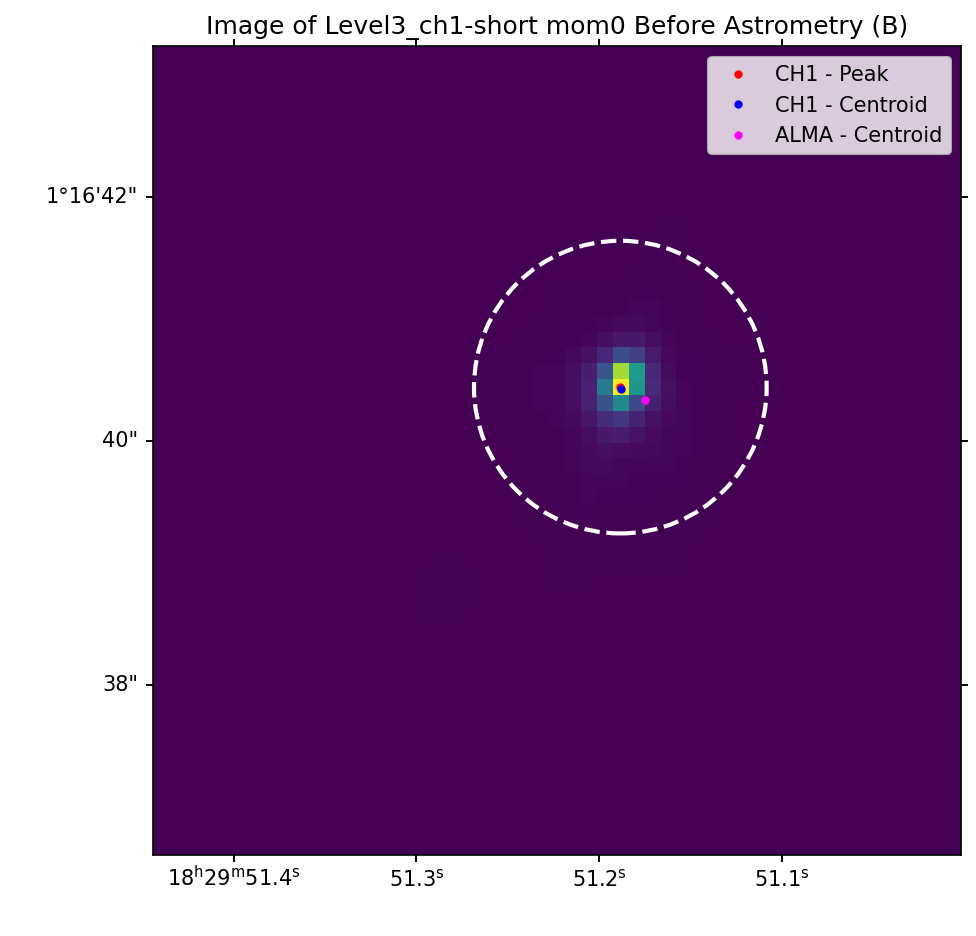

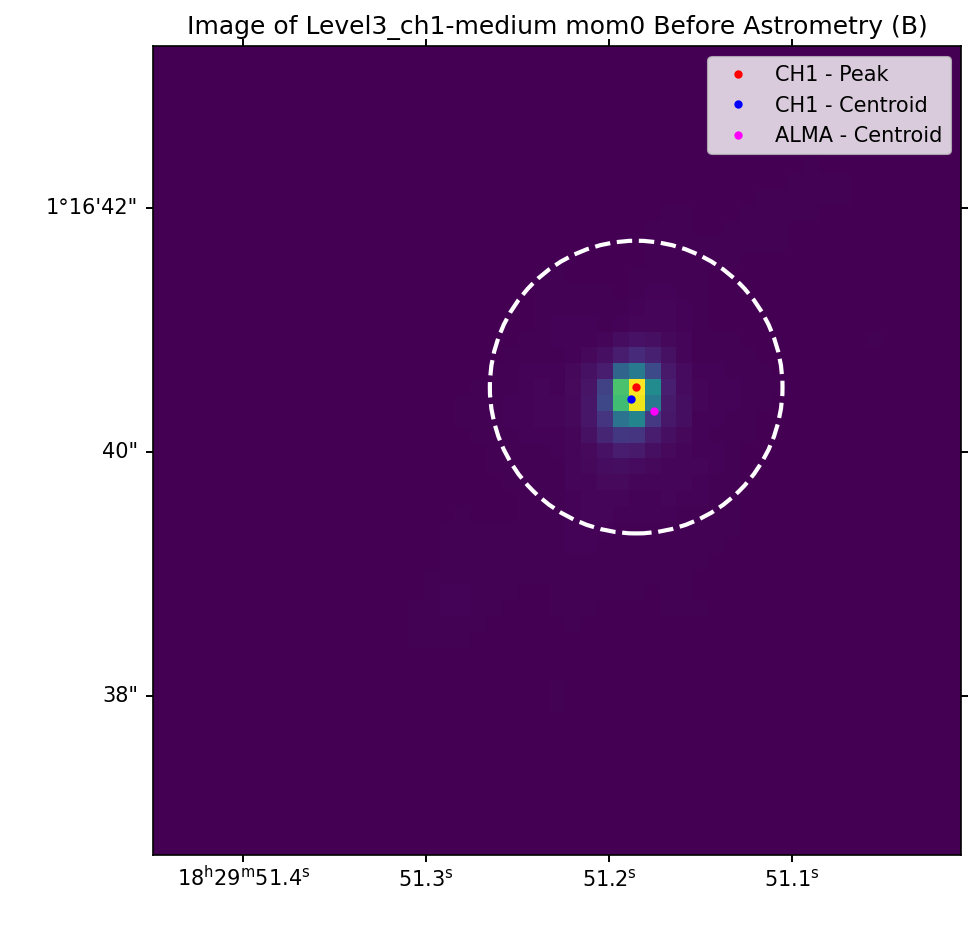

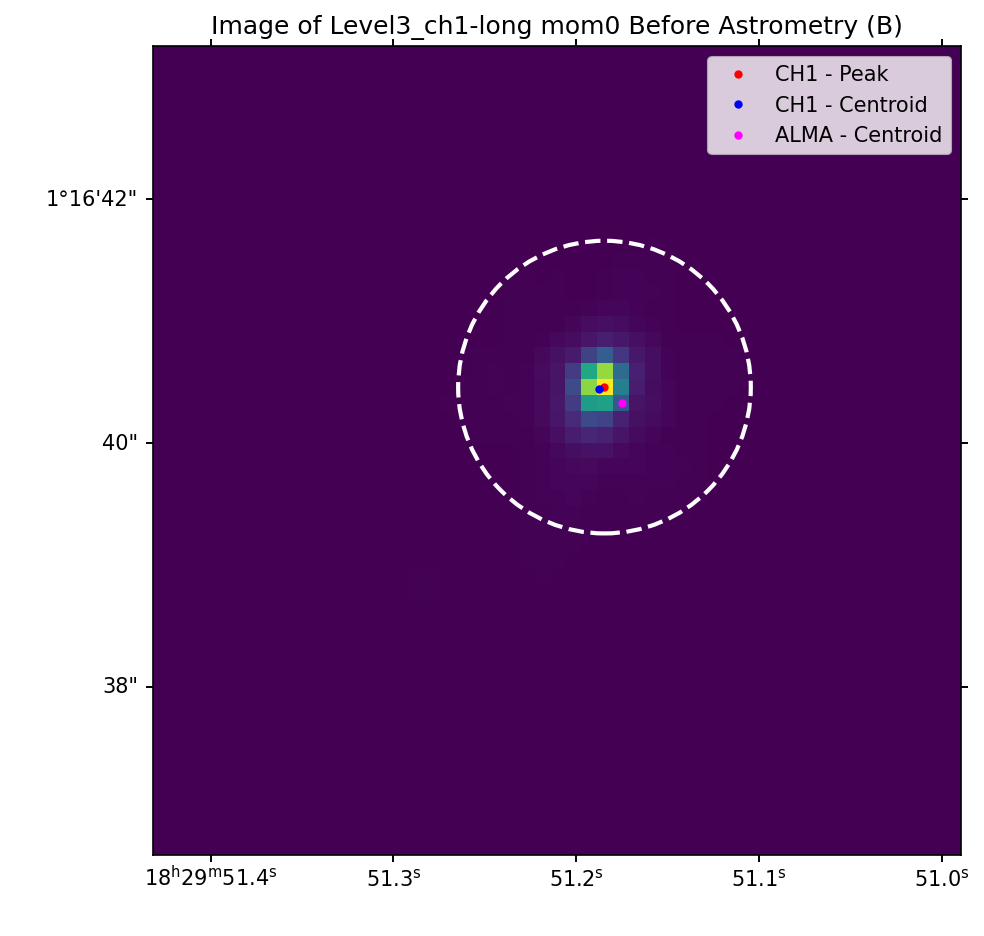

In [ ]:
mr_ch1_B = ['Level3_ch1-short_s3d.fits', 'Level3_ch1-medium_s3d.fits', 'Level3_ch1-long_s3d.fits']
mr_ch1_B_mom0 = ['Level3_ch1-short_s3d_b_mom0.fits', 'Level3_ch1-medium_s3d_b_mom0.fits', 'Level3_ch1-long_s3d_b_mom0.fits']

for i in range(len(mr_ch1_B)):
    hdu_B_mr1 = fits.open(dmiri_B+mr_ch1_B[i])
    hinfo_B_mr1 = hdu_B_mr1[1].header ; hinfo_B_mr1_0 = hdu_B_mr1[0].header ; data_B_mr1 = hdu_B_mr1[1].data

    hdu_B_mr1_mom0 = fits.open(dmiri_B_mom0+mr_ch1_B_mom0[i])
    hinfo_B_mr1_mom0 = hdu_B_mr1_mom0[0].header ; data_B_mr1_mom0 = hdu_B_mr1_mom0[0].data

    w_mr1 = WCS(hinfo_B_mr1_mom0).celestial
    '''
    Centroid
    '''
    mr1_ap, mr1_ap_stats = Cent_ApStats(w_mr1, data_B_mr1_mom0, 1.2)
    mr1_ap_cent_deg = mr1_ap_stats.sky_centroid
    mr1_ap_centroid_ra = mr1_ap_stats.centroid[0] ; mr1_ap_centroid_dec = mr1_ap_stats.centroid[1]

    '''
    Peak
    '''
    mr1_peak = np.where(data_B_mr1_mom0 == np.nanmax(data_B_mr1_mom0))
    mr1_peak_ra, mr1_peak_dec = mr1_peak[1][0], mr1_peak[0][0]
    mr1_peak_coords_deg = w_mr1.pixel_to_world(mr1_peak_ra, mr1_peak_dec)



    fig  = plt.figure(figsize=(7,7), dpi=150)
    gs = gridspec.GridSpec(figure=fig, nrows=1, ncols=1)
    ax0 = fig.add_subplot(gs[0,0], projection = w_mr1)
    ax0.imshow(data_B_mr1_mom0)
    ap_plot0 = mr1_ap.to_pixel(w_mr1)
    ap_plot0.plot(ax=ax0, color='white', lw=2, ls='--')
    ax0.plot(mr1_peak_ra, mr1_peak_dec, color='r', marker='o', ls='', ms=3, label='CH1 - Peak')
    ax0.plot(mr1_ap_centroid_ra, mr1_ap_centroid_dec, color='b', marker='o',ls='', ms=3, label='CH1 - Centroid')
    Cent_mr1_alma_coords = w_mr1.world_to_pixel(alma_ap_cent_deg)
    ax0.plot(Cent_mr1_alma_coords[0], Cent_mr1_alma_coords[1], color='magenta', marker='o', ls='', ms=3, label='ALMA - Centroid')
    ax0.set_xlabel(' ')
    ax0.set_ylabel(' ')
    ax0.legend()
    ax0.set_title(r'Image of '+mr_ch1_B_mom0[i][:-16]+' mom0 Before Astrometry (B)')

    #plt.savefig(dfig+mr_ch1_B_mom0[i][:-5]+'_prf_Astrometry_v5_centroid_peak.png', dpi=150, bbox_inches='tight')

    del_ra_mr1_B = dms2deg(mr1_ap_cent_deg.ra - alma_ap_cent_deg.ra)
    del_dec_mr1_B = dms2deg(mr1_ap_cent_deg.dec - alma_ap_cent_deg.dec)

    hinfo_B_mr1_new = deepcopy(hinfo_B_mr1)
    hinfo_B_mr1_new['CRVAL1'] = hinfo_B_mr1_new['CRVAL1'] - del_ra_mr1_B
    hinfo_B_mr1_new['CRVAL2'] = hinfo_B_mr1_new['CRVAL2'] - del_dec_mr1_B
    fits.writeto(dmiri_B+'astrometry_v5/'+mr_ch1_B[i][:-5]+'_AstrometryV5_centroid.fits',  data_B_mr1, header=hinfo_B_mr1_0+hinfo_B_mr1_new, overwrite=True)#

#### Checking after astrometry - CH1

Set DATE-AVG to '2024-05-10T00:39:07.915' from MJD-AVG'. [astropy.wcs.wcs]
Set OBSGEO-B to   -24.749966 from OBSGEO-[XYZ].
Set OBSGEO-H to 1591175882.015 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-05-10T01:06:37.021' from MJD-AVG'. [astropy.wcs.wcs]
Set OBSGEO-B to   -24.759599 from OBSGEO-[XYZ].
Set OBSGEO-H to 1591323131.874 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2024-05-10T01:33:38.396' from MJD-AVG'. [astropy.wcs.wcs]
Set OBSGEO-B to   -24.768788 from OBSGEO-[XYZ].
Set OBSGEO-H to 1591463644.255 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


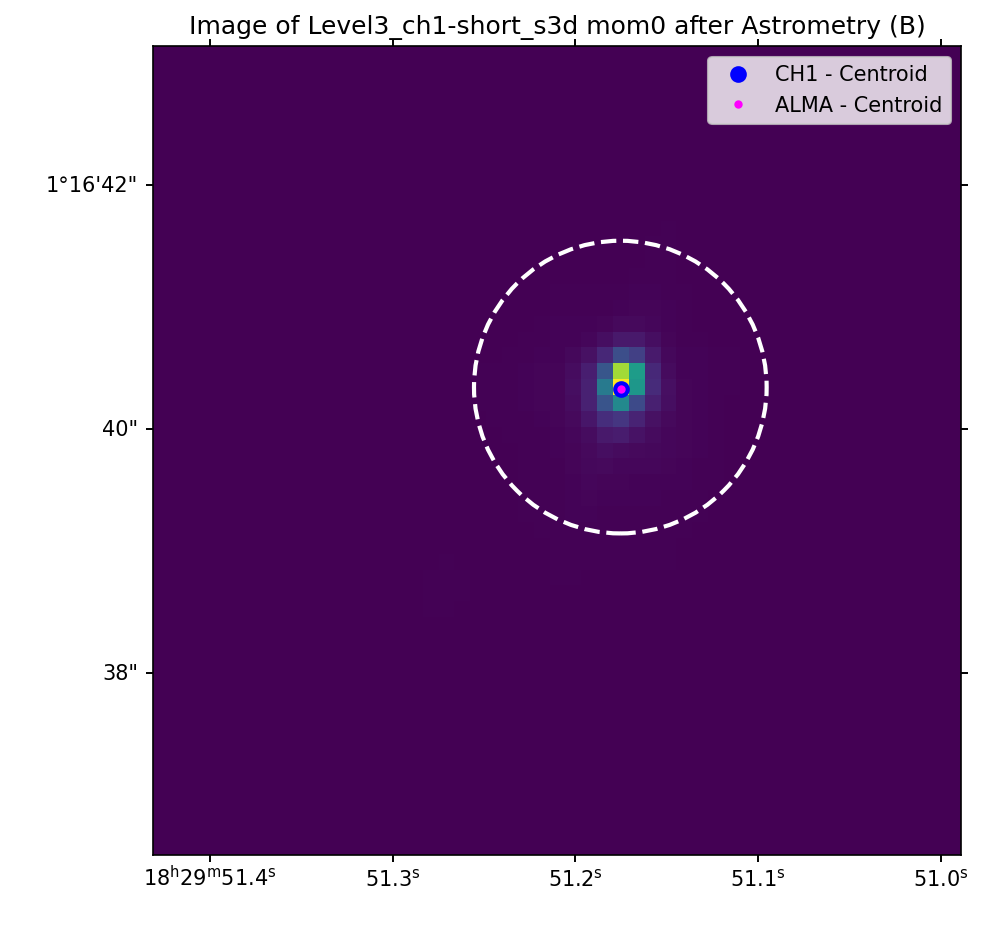

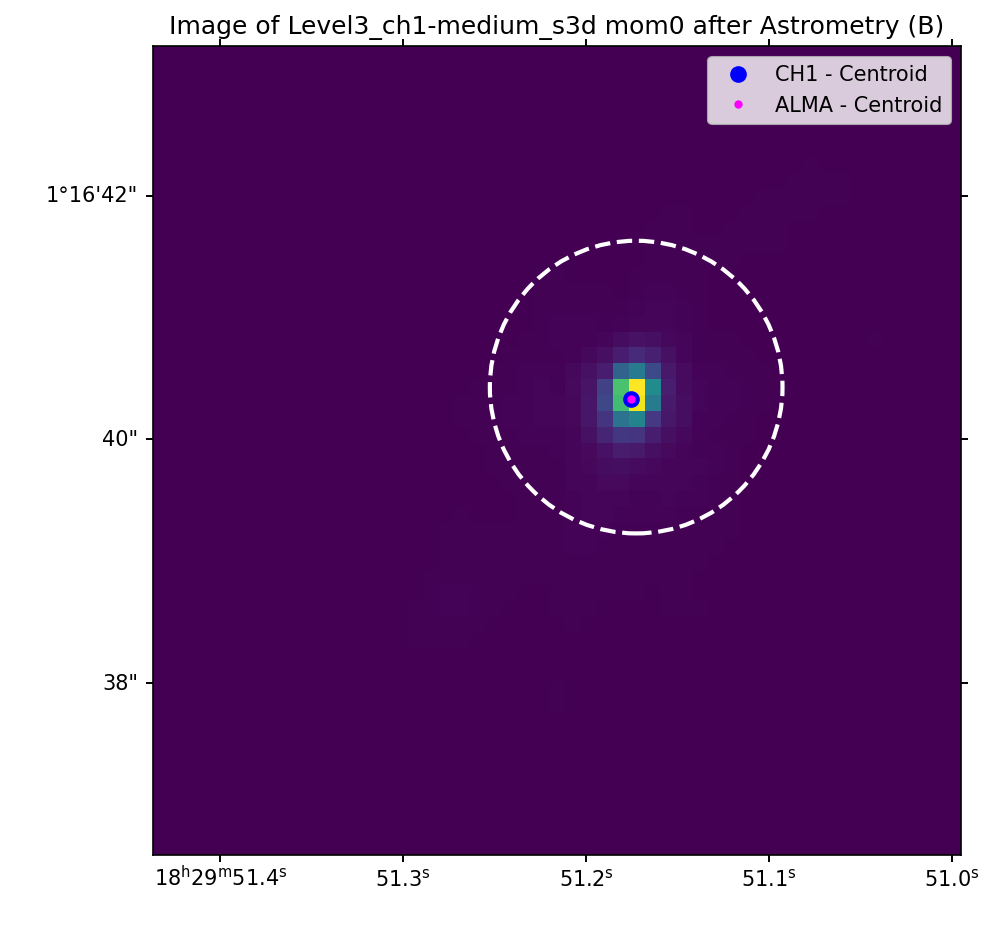

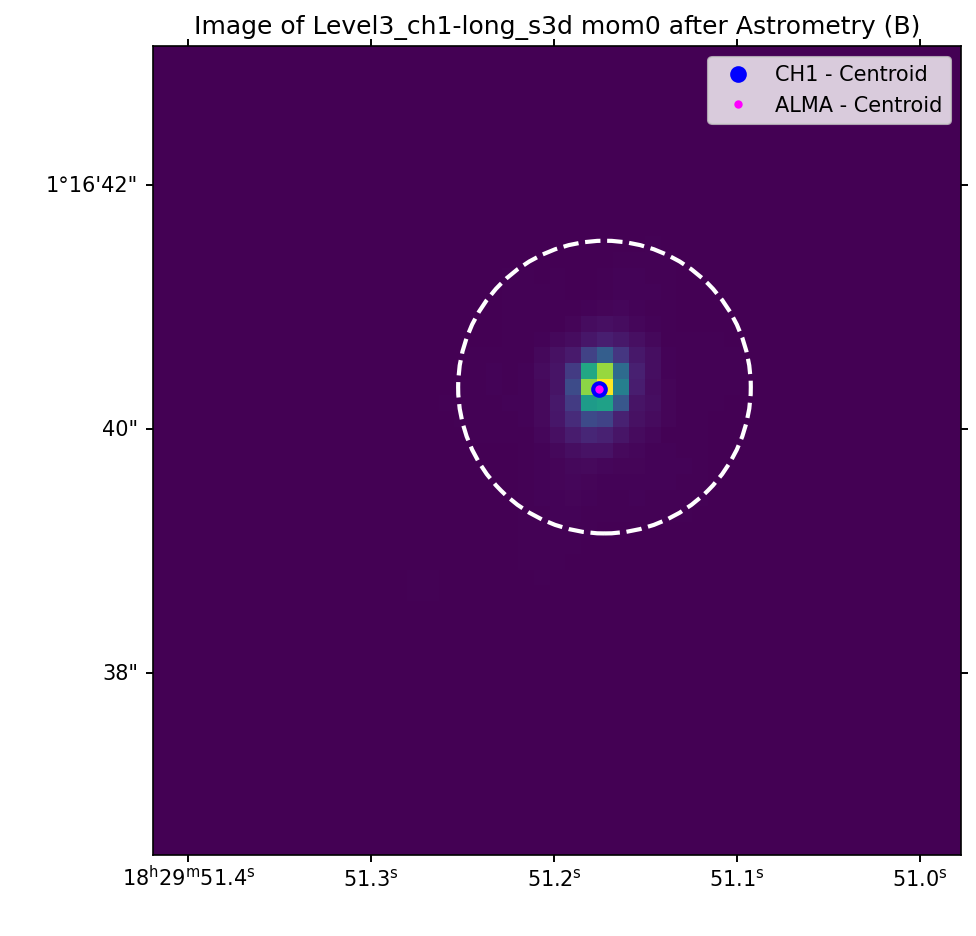

In [ ]:
mr_ch1_B_mom0_astrometry = ['Level3_ch1-short_s3d_AstrometryV5_centroid_b_mom0.fits', 'Level3_ch1-medium_s3d_AstrometryV5_centroid_b_mom0.fits', 'Level3_ch1-long_s3d_AstrometryV5_centroid_b_mom0.fits']

for i in range(len(mr_ch1_B)):
    hdu_B_mr1_mom0 = fits.open(dmiri_B_mom0_astrometry+mr_ch1_B_mom0_astrometry[i])
    hinfo_B_mr1_mom0 = hdu_B_mr1_mom0[0].header ; data_B_mr1_mom0 = hdu_B_mr1_mom0[0].data

    w_mr1 = WCS(hinfo_B_mr1_mom0).celestial
    '''
    Centroid
    '''
    mr1_ap, mr1_ap_stats = Cent_ApStats(w_mr1, data_B_mr1_mom0, 1.2)
    mr1_ap_cent_deg = mr1_ap_stats.sky_centroid
    mr1_ap_centroid_ra = mr1_ap_stats.centroid[0] ; mr1_ap_centroid_dec = mr1_ap_stats.centroid[1]

    '''
    Peak
    '''
    mr1_peak = np.where(data_B_mr1_mom0 == np.nanmax(data_B_mr1_mom0))
    mr1_peak_ra, mr1_peak_dec = mr1_peak[1][0], mr1_peak[0][0]
    mr1_peak_coords_deg = w_mr1.pixel_to_world(mr1_peak_ra, mr1_peak_dec)



    fig  = plt.figure(figsize=(7,7), dpi=150)
    gs = gridspec.GridSpec(figure=fig, nrows=1, ncols=1)
    ax0 = fig.add_subplot(gs[0,0], projection = w_mr1)
    ax0.imshow(data_B_mr1_mom0)
    ap_plot0 = mr1_ap.to_pixel(w_mr1)
    ap_plot0.plot(ax=ax0, color='white', lw=2, ls='--')
    ax0.plot(mr1_ap_centroid_ra, mr1_ap_centroid_dec, color='b', marker='o',ls='', ms=7, label='CH1 - Centroid')
    Cent_mr1_alma_coords = w_mr1.world_to_pixel(alma_ap_cent_deg)
    ax0.plot(Cent_mr1_alma_coords[0], Cent_mr1_alma_coords[1], color='magenta', marker='o', ls='', ms=3, label='ALMA - Centroid')
    ax0.set_xlabel(' ')
    ax0.set_ylabel(' ')
    ax0.legend()
    ax0.set_title(r'Image of '+mr_ch1_B_mom0_astrometry[i][:-34]+' mom0 after Astrometry (B)')

    #plt.savefig(dfig+mr_ch1_B_mom0[i][:-5]+'_prf_Astrometry_v5_after.png', dpi=150, bbox_inches='tight')

## NIRSpec

In [ ]:
ind_5_ns_g395_n2 = 3203
ind_3p95_ns_g395_n1 = 1624
ind_2p75_ns_g235_n2 = 2752
ind_2p3_ns_g235_n1 = 1616

### ALMA Cont Centroid & NIRSpec g395 mom0 Peak

Set DATE-AVG to '2024-05-09T23:36:32.507' from MJD-AVG.
Set DATE-END to '2024-05-09T23:55:16.057' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -24.726211 from OBSGEO-[XYZ].
Set OBSGEO-H to 1590813026.187 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


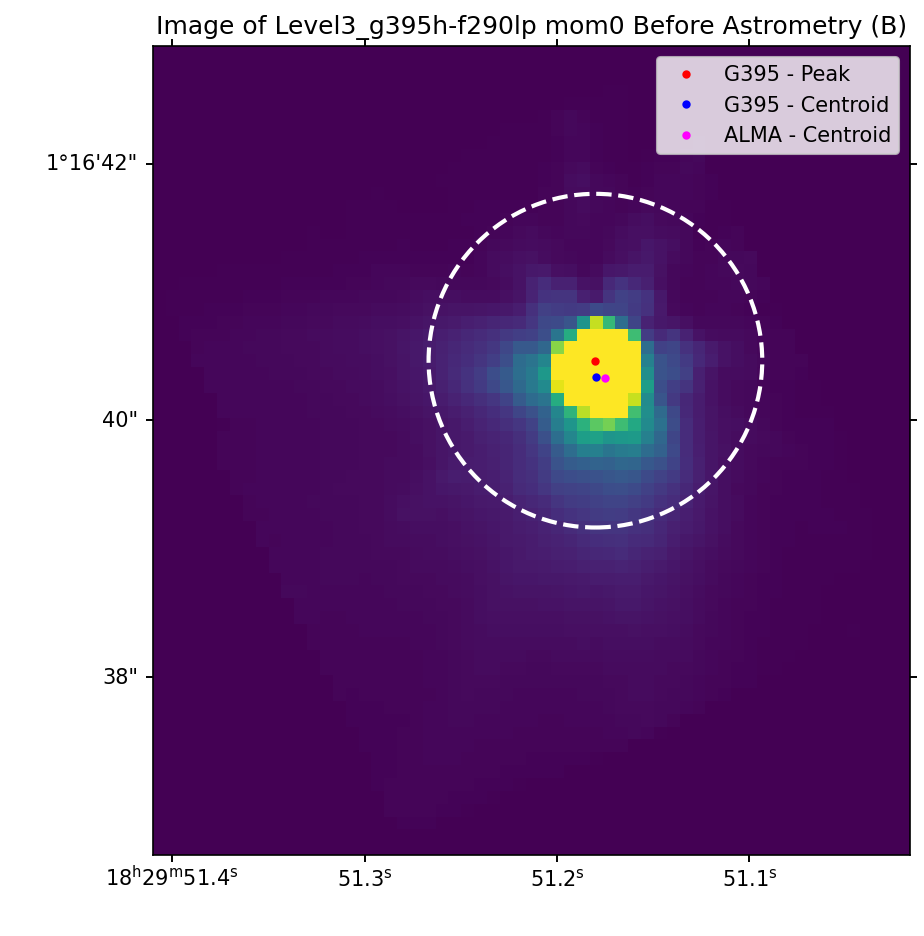

In [ ]:
dns_B = '/dataPath/'
dns_B_mom0 = '/dataPath/moment/'
ns_g395_B = 'Level3_g395h-f290lp_s3d.fits'
ns_g395_B_mom0 = 'Level3_g395h-f290lp_s3d_b_mom0.fits'

hdu_B_nsg395 = fits.open(dns_B+ns_g395_B)
hinfo_B_nsg395 = hdu_B_nsg395[1].header ; hinfo_B_nsg395_0 = hdu_B_nsg395[0].header ; data_B_nsg395 = hdu_B_nsg395[1].data

hdu_B_nsg395_mom0 = fits.open(dns_B_mom0+ns_g395_B_mom0)
hinfo_B_nsg395_mom0 = hdu_B_nsg395_mom0[0].header ; data_B_nsg395_mom0 = hdu_B_nsg395_mom0[0].data

w_nsg395 = WCS(hinfo_B_nsg395_mom0).celestial

'''
Centroid
'''
nsg395_ap, nsg395_ap_stats = Cent_ApStats(w_nsg395, data_B_nsg395_mom0, 1.3)
nsg395_ap_cent_deg = nsg395_ap_stats.sky_centroid
nsg395_ap_centroid_ra = nsg395_ap_stats.centroid[0] ; nsg395_ap_centroid_dec = nsg395_ap_stats.centroid[1]

'''
Peak
'''
nsg395_peak = np.where(data_B_nsg395_mom0 == np.nanmax(data_B_nsg395_mom0))
nsg395_peak_ra, nsg395_peak_dec = nsg395_peak[1][0], nsg395_peak[0][0]
nsg395_peak_coords_deg = w_nsg395.pixel_to_world(nsg395_peak_ra, nsg395_peak_dec)

fig  = plt.figure(figsize=(7,7), dpi=150)
gs = gridspec.GridSpec(figure=fig, nrows=1, ncols=1)
ax0 = fig.add_subplot(gs[0,0], projection = w_nsg395)
ax0.imshow(data_B_nsg395_mom0, vmin=-1e3, vmax=1e7)
ap_plot0 = nsg395_ap.to_pixel(w_nsg395)
ap_plot0.plot(ax=ax0, color='white', lw=2, ls='--')
ax0.plot(nsg395_peak_ra, nsg395_peak_dec, color='r', marker='o', ls='', ms=3, label='G395 - Peak')
ax0.plot(nsg395_ap_centroid_ra, nsg395_ap_centroid_dec, color='b', marker='o',ls='', ms=3, label='G395 - Centroid')
Cent_nsg395_alma_coords = w_nsg395.world_to_pixel(alma_ap_cent_deg)
ax0.plot(Cent_nsg395_alma_coords[0], Cent_nsg395_alma_coords[1], color='magenta', marker='o', ls='', ms=3, label='ALMA - Centroid')

ax0.set_xlabel(' ')
ax0.set_ylabel(' ')
ax0.legend()
ax0.set_title(r'Image of '+ns_g395_B_mom0[:-16]+' mom0 Before Astrometry (B)')

plt.savefig(dfig+ns_g395_B_mom0[:-5]+'_Astrometry_v5_centroid_peak.png', dpi=150, bbox_inches='tight')

del_ra_nsg395_B = dms2deg(nsg395_peak_coords_deg.ra - alma_ap_cent_deg.ra)
del_dec_nsg395_B = dms2deg(nsg395_peak_coords_deg.dec - alma_ap_cent_deg.dec)


hinfo_B_nsg395_new = deepcopy(hinfo_B_nsg395)
hinfo_B_nsg395_new['CRVAL1'] = hinfo_B_nsg395_new['CRVAL1'] - del_ra_nsg395_B
hinfo_B_nsg395_new['CRVAL2'] = hinfo_B_nsg395_new['CRVAL2'] - del_dec_nsg395_B
fits.writeto(dns_B+'astrometry_v5/'+ns_g395_B[:-5]+'_sp_AstrometryV5_peak.fits',  data_B_nsg395, header=hinfo_B_nsg395_0+hinfo_B_nsg395_new, overwrite=True)#

#### Checking after astrometry - g395

Set DATE-AVG to '2024-05-09T23:36:32.507' from MJD-AVG'. [astropy.wcs.wcs]
Set OBSGEO-B to   -24.726211 from OBSGEO-[XYZ].
Set OBSGEO-H to 1590813026.187 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


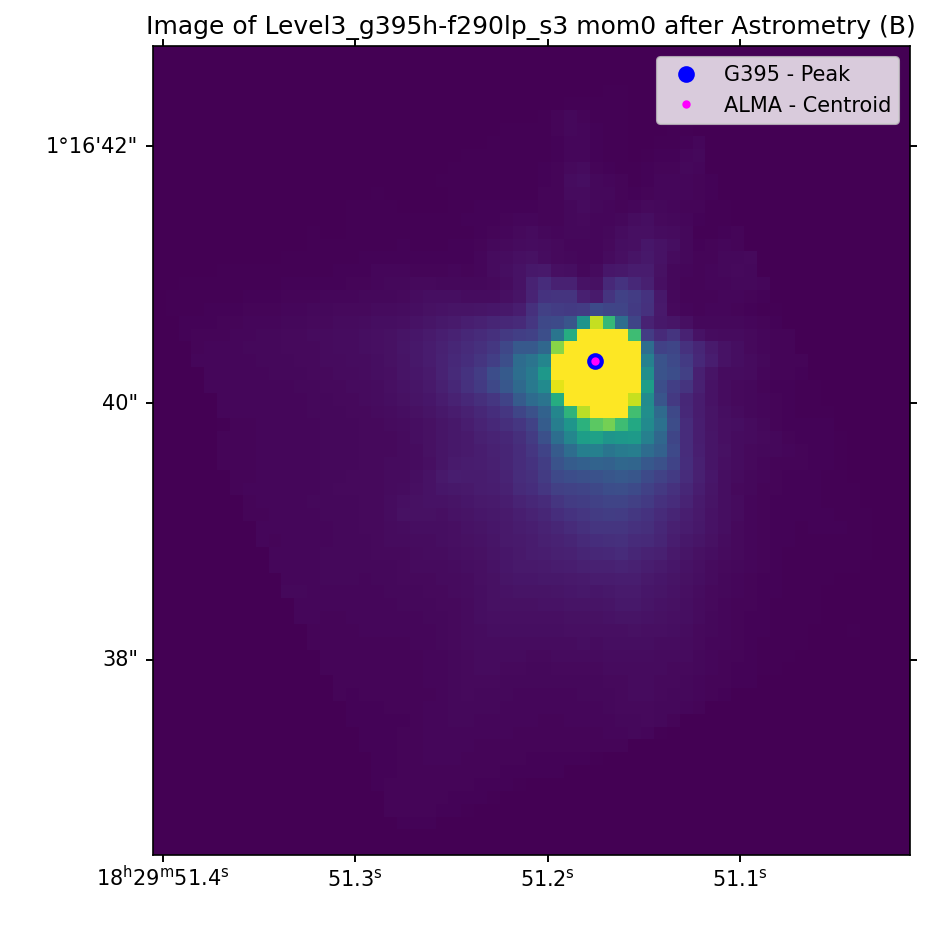

In [ ]:
dns_B_mom0_astrometry = '/dataPath/'
ns_g395_B_mom0_astrometry = 'Level3_g395h-f290lp_s3d_sp_AstrometryV5_peak_b_mom0.fits'

hdu_B_nsg395_mom0 = fits.open(dns_B_mom0_astrometry+ns_g395_B_mom0_astrometry)
hinfo_B_nsg395_mom0 = hdu_B_nsg395_mom0[0].header ; data_B_nsg395_mom0 = hdu_B_nsg395_mom0[0].data

w_nsg395 = WCS(hinfo_B_nsg395_mom0).celestial

'''
Peak
'''
nsg395_peak = np.where(data_B_nsg395_mom0 == np.nanmax(data_B_nsg395_mom0))
nsg395_peak_ra, nsg395_peak_dec = nsg395_peak[1][0], nsg395_peak[0][0]
nsg395_peak_coords_deg = w_nsg395.pixel_to_world(nsg395_peak_ra, nsg395_peak_dec)



fig  = plt.figure(figsize=(7,7), dpi=150)
gs = gridspec.GridSpec(figure=fig, nrows=1, ncols=1)
ax0 = fig.add_subplot(gs[0,0], projection = w_nsg395)
ax0.imshow(data_B_nsg395_mom0, vmin=-1e3, vmax=1e7)
# ap_plot0 = mr4_ap.to_pixel(w_mr4)
# ap_plot0.plot(ax=ax0, color='white', lw=2, ls='--')
ax0.plot(nsg395_peak_ra, nsg395_peak_dec, color='b', marker='o',ls='', ms=7, label='G395 - Peak')
Cent_nsg395_alma_coords = w_nsg395.world_to_pixel(alma_ap_cent_deg)
ax0.plot(Cent_nsg395_alma_coords[0], Cent_nsg395_alma_coords[1], color='magenta', marker='o', ls='', ms=3, label='ALMA - Centroid')

ax0.set_xlabel(' ')
ax0.set_ylabel(' ')
ax0.legend()
ax0.set_title(r'Image of '+ns_g395_B_mom0_astrometry[:-34]+' mom0 after Astrometry (B)')

plt.savefig(dfig+ns_g395_B_mom0_astrometry[:-5]+'_Astrometry_v5_after.png', dpi=150, bbox_inches='tight')

### ALMA Cont Centroid & NIRSpec g235 mom0 Peak

Set DATE-AVG to '2024-05-09T22:47:32.756' from MJD-AVG.
Set DATE-END to '2024-05-09T23:14:17.435' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -24.707270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1590523978.084 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


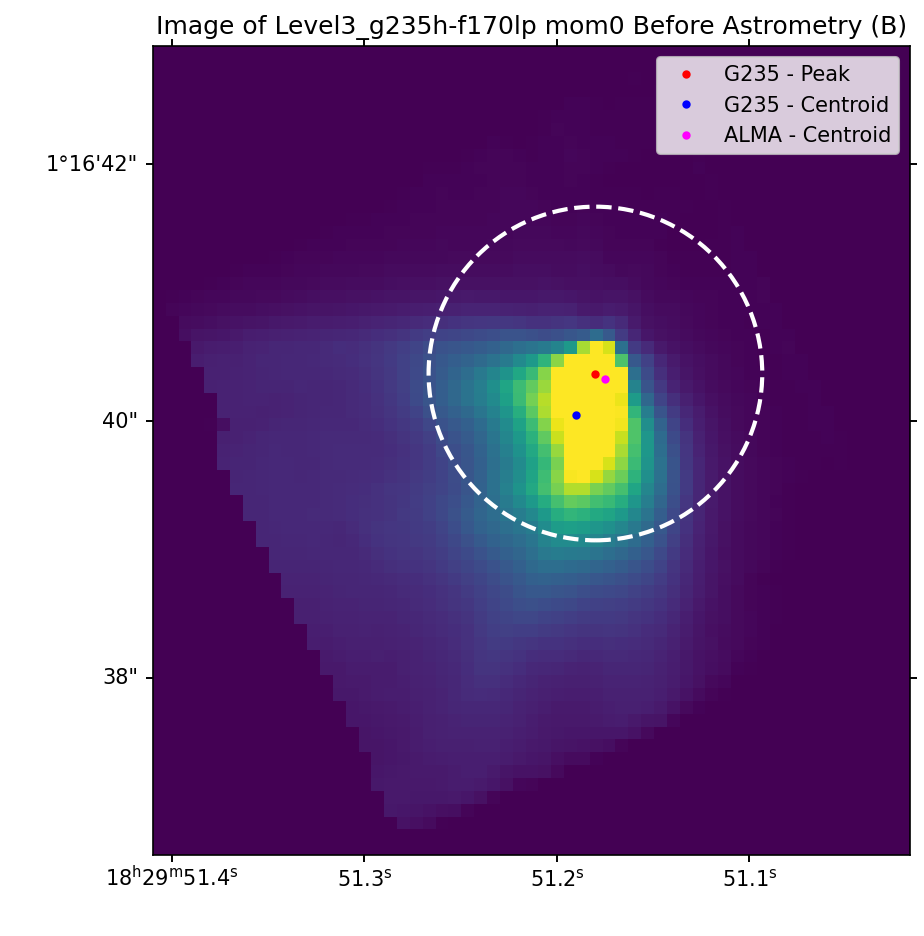

In [ ]:
dns_B = '/dataPath/'
dns_B_mom0 = '/dataPath/moment/'
ns_g235_B = 'Level3_g235h-f170lp_s3d.fits'
ns_g235_B_mom0 = 'Level3_g235h-f170lp_s3d_b_mom0.fits'

hdu_B_nsg235 = fits.open(dns_B+ns_g235_B)
hinfo_B_nsg235 = hdu_B_nsg235[1].header ; hinfo_B_nsg235_0 = hdu_B_nsg235[0].header ; data_B_nsg235 = hdu_B_nsg235[1].data

hdu_B_nsg235_mom0 = fits.open(dns_B_mom0+ns_g235_B_mom0)
hinfo_B_nsg235_mom0 = hdu_B_nsg235_mom0[0].header ; data_B_nsg235_mom0 = hdu_B_nsg235_mom0[0].data

w_nsg235 = WCS(hinfo_B_nsg235_mom0).celestial

'''
Centroid
'''
nsg235_ap, nsg235_ap_stats = Cent_ApStats(w_nsg235, data_B_nsg235_mom0, 1.3)
nsg235_ap_cent_deg = nsg235_ap_stats.sky_centroid
nsg235_ap_centroid_ra = nsg235_ap_stats.centroid[0] ; nsg235_ap_centroid_dec = nsg235_ap_stats.centroid[1]

'''
Peak
'''
nsg235_peak = np.where(data_B_nsg235_mom0 == np.nanmax(data_B_nsg235_mom0))
nsg235_peak_ra, nsg235_peak_dec = nsg235_peak[1][0], nsg235_peak[0][0]
nsg235_peak_coords_deg = w_nsg235.pixel_to_world(nsg235_peak_ra, nsg235_peak_dec)

fig  = plt.figure(figsize=(7,7), dpi=150)
gs = gridspec.GridSpec(figure=fig, nrows=1, ncols=1)
ax0 = fig.add_subplot(gs[0,0], projection = w_nsg235)
ax0.imshow(data_B_nsg235_mom0, vmin=-1e3, vmax=1e6)
ap_plot0 = nsg235_ap.to_pixel(w_nsg235)
ap_plot0.plot(ax=ax0, color='white', lw=2, ls='--')
ax0.plot(nsg235_peak_ra, nsg235_peak_dec, color='r', marker='o', ls='', ms=3, label='G235 - Peak')
ax0.plot(nsg235_ap_centroid_ra, nsg235_ap_centroid_dec, color='b', marker='o',ls='', ms=3, label='G235 - Centroid')
Cent_nsg235_alma_coords = w_nsg235.world_to_pixel(alma_ap_cent_deg)
ax0.plot(Cent_nsg235_alma_coords[0], Cent_nsg235_alma_coords[1], color='magenta', marker='o', ls='', ms=3, label='ALMA - Centroid')

ax0.set_xlabel(' ')
ax0.set_ylabel(' ')
ax0.legend()
ax0.set_title(r'Image of '+ns_g235_B_mom0[:-16]+' mom0 Before Astrometry (B)')

plt.savefig(dfig+ns_g235_B_mom0[:-5]+'_Astrometry_v5_centroid_peak.png', dpi=150, bbox_inches='tight')

del_ra_nsg235_B = dms2deg(nsg235_peak_coords_deg.ra - alma_ap_cent_deg.ra)
del_dec_nsg235_B = dms2deg(nsg235_peak_coords_deg.dec - alma_ap_cent_deg.dec)


hinfo_B_nsg235_new = deepcopy(hinfo_B_nsg235)
hinfo_B_nsg235_new['CRVAL1'] = hinfo_B_nsg235_new['CRVAL1'] - del_ra_nsg235_B
hinfo_B_nsg235_new['CRVAL2'] = hinfo_B_nsg235_new['CRVAL2'] - del_dec_nsg235_B
fits.writeto(dns_B+'astrometry_v5/'+ns_g235_B[:-5]+'_sp_AstrometryV5_peak.fits',  data_B_nsg235, header=hinfo_B_nsg235_0+hinfo_B_nsg235_new, overwrite=True)#

#### Checking after astrometry - g235

Set DATE-AVG to '2024-05-09T22:47:32.756' from MJD-AVG'. [astropy.wcs.wcs]
Set OBSGEO-B to   -24.707270 from OBSGEO-[XYZ].
Set OBSGEO-H to 1590523978.084 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


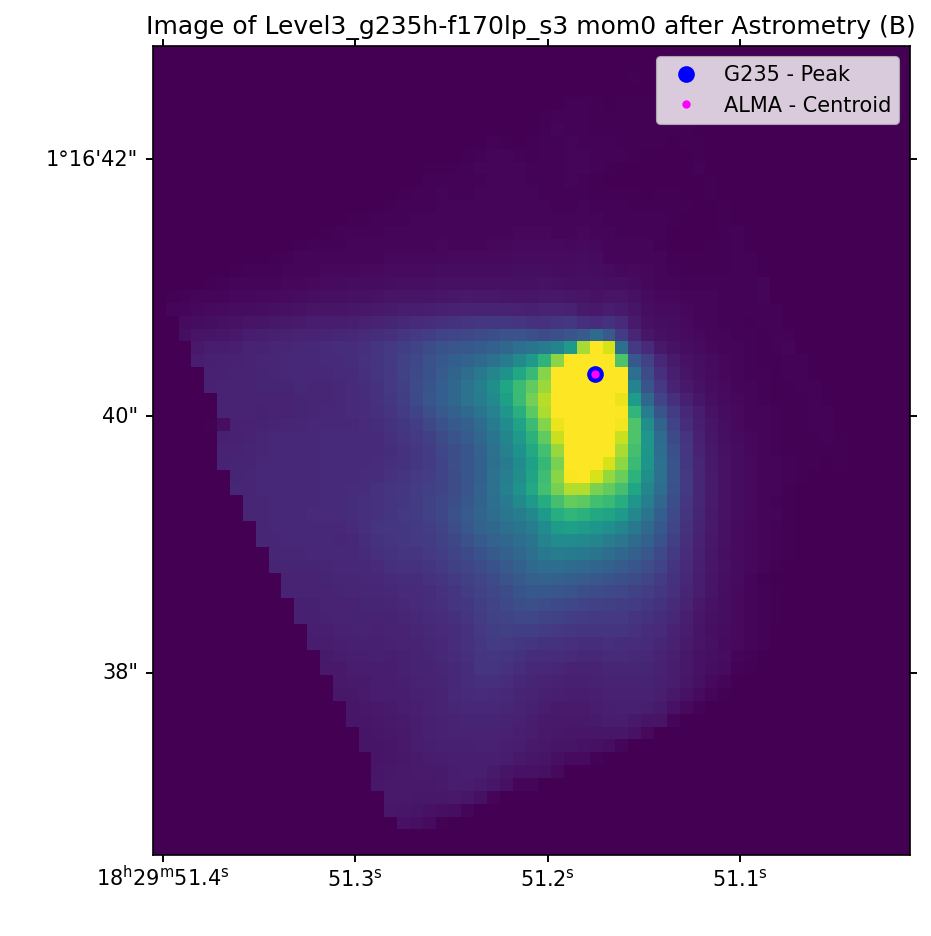

In [ ]:
dns_B_mom0_astrometry = '/dataPath/'
ns_g235_B_mom0_astrometry = 'Level3_g235h-f170lp_s3d_sp_AstrometryV5_peak_b_mom0.fits'

hdu_B_nsg235_mom0 = fits.open(dns_B_mom0_astrometry+ns_g235_B_mom0_astrometry)
hinfo_B_nsg235_mom0 = hdu_B_nsg235_mom0[0].header ; data_B_nsg235_mom0 = hdu_B_nsg235_mom0[0].data

w_nsg235 = WCS(hinfo_B_nsg235_mom0).celestial

'''
Peak
'''
nsg235_peak = np.where(data_B_nsg235_mom0 == np.nanmax(data_B_nsg235_mom0))
nsg235_peak_ra, nsg235_peak_dec = nsg235_peak[1][0], nsg235_peak[0][0]
nsg235_peak_coords_deg = w_nsg235.pixel_to_world(nsg235_peak_ra, nsg235_peak_dec)



fig  = plt.figure(figsize=(7,7), dpi=150)
gs = gridspec.GridSpec(figure=fig, nrows=1, ncols=1)
ax0 = fig.add_subplot(gs[0,0], projection = w_nsg235)
ax0.imshow(data_B_nsg235_mom0, vmin=-1e3, vmax=1e6)
# ap_plot0 = mr4_ap.to_pixel(w_mr4)
# ap_plot0.plot(ax=ax0, color='white', lw=2, ls='--')
ax0.plot(nsg235_peak_ra, nsg235_peak_dec, color='b', marker='o',ls='', ms=7, label='G235 - Peak')
Cent_nsg235_alma_coords = w_nsg235.world_to_pixel(alma_ap_cent_deg)
ax0.plot(Cent_nsg235_alma_coords[0], Cent_nsg235_alma_coords[1], color='magenta', marker='o', ls='', ms=3, label='ALMA - Centroid')

ax0.set_xlabel(' ')
ax0.set_ylabel(' ')
ax0.legend()
ax0.set_title(r'Image of '+ns_g235_B_mom0_astrometry[:-34]+' mom0 after Astrometry (B)')

plt.savefig(dfig+ns_g235_B_mom0_astrometry[:-5]+'_Astrometry_v5_after.png', dpi=150, bbox_inches='tight')